In [4]:
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,make_scorer,classification_report
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, cross_validate,GridSearchCV,RandomizedSearchCV,train_test_split, cross_val_score
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import Pipeline, FunctionTransformer
import types
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from lib.NaiveBayesClassifier import NaiveBayesClassifier
from sklearn.feature_selection import mutual_info_regression
from lib.Classifier import Classifier
from sklearn.preprocessing import MinMaxScaler
from functools import cache
from scipy import signal
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
np.set_printoptions(precision=6, suppress=True)

In [5]:
# pip install scikeras[tensorflow]

In [6]:
    
def display_results(labels_test,rfc_pred):
    acc = accuracy_score(labels_test, rfc_pred)
    f1 = f1_score(labels_test, rfc_pred, average='macro')
    print(classification_report(labels_test,rfc_pred, digits=4))

    aux_df = labels_test.drop_duplicates().sort_values()
    conf_matrix = confusion_matrix(labels_test, rfc_pred)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                xticklabels=aux_df.values, 
                yticklabels=aux_df.values,
                cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    plt.show()
    return f1,acc

@cache
def transform_channel_per_event(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(pca.transform(event.T))
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list.T

@cache
def transform_data_per_event(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(pca.transform(event).T)
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list.T

@cache
def umap_transform_channel_per_channel(array_name:str,umap):
    array = globals()[array_name]
    transform_list = []
    for channel in range(64):
        transform_list.append(umap.transform(array[:,channel,:]).T)
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list

@cache
def transform_channel_per_event_csp(array_name:str,pca,csp):

    return csp.transform(transform_channel_per_event(array_name,pca))

@cache
def transform_data_per_event_csp(array_name:str,pca,csp):

    return csp.transform(transform_data_per_event(array_name,pca))

@cache
def transform_csp(array_name:str,csp):
    array = globals()[array_name]
    return csp.transform(array)

@cache
def concat_channels(array_name:str):
    array = globals()[array_name]
    list_array = []
    for event in array:
        list_array.append(np.concatenate(event))
    return np.vstack(list_array)

@cache
def transform_all_concat(array_name:str,pca):
    return pca.transform(concat_channels(array_name))

@cache
def transform_channel_concat(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(np.concatenate(pca.transform(event.T)))
    transform_list = np.vstack(transform_list) 
    return transform_list

@cache
def transform_data_concat(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(np.concatenate(pca.transform(event).T))
    transform_list = np.vstack(transform_list) 
    return transform_list


def create_model(my_params):
    model = tf.keras.Sequential(my_params["layers"])
    model.compile(
        optimizer=my_params["optimizer"],
        loss=my_params["loss"],
        metrics=my_params["metrics"])
    return model

def butter_bandpass(lowcut,highcut,fs,order):
    nyq=0.5*fs
    low=lowcut/nyq
    high=highcut/nyq
    b,a = signal.butter(8,[low,high],'bandpass')
    return b,a
def butter_bandpass_filter(data,lowcut,highcut,fs,order):
    b,a=butter_bandpass(lowcut,highcut,fs,order)
    y=signal.filtfilt(b,a,data,axis=2)
    return y


@cache
def transform_FBCSP(array_name:str,csps_list_name:str,freq=[4,8,12,16,20,24,28,32,36,40]):
    array = globals()[array_name]
    csps = globals()[csps_list_name]
    features_test=[]
    for freq_count in range(len(freq)):
    #loop for freqency
        lower=freq[freq_count]
        if lower==freq[-1]:
            break
        csp=csps[freq_count]
        higher=freq[freq_count+1]
        X_test_filt=butter_bandpass_filter(array,lowcut=lower,highcut=higher,fs=128,order=8)
        tmp_test=csp.transform(X_test_filt)
        if freq_count==0:
            features_test=tmp_test
        else:
            features_test=np.concatenate((features_test,tmp_test),axis=1)
    return features_test

@cache
def transform_FBCSP_channel(array_name:str,csps_list_name:str,pca,freq=[4,8,12,16,20,24,28,32,36,40]):
    csps = globals()[csps_list_name]
    array = transform_channel_per_event(array_name,pca)
    features_test=[]
    for freq_count in range(len(freq)):
    #loop for freqency
        lower=freq[freq_count]
        if lower==freq[-1]:
            break
        csp=csps[freq_count]
        higher=freq[freq_count+1]
        X_test_filt=butter_bandpass_filter(array,lowcut=lower,highcut=higher,fs=128,order=8)
        tmp_test=csp.transform(X_test_filt)
        if freq_count==0:
            features_test=tmp_test
        else:
            features_test=np.concatenate((features_test,tmp_test),axis=1)
    return features_test

class Pipe:

    def __init__(self,name, model, processed_X_train,processed_X_val, adapter = None):
        self.name = name
        self.model = model
        self.processed_X_train = processed_X_train
        self.processed_X_val = processed_X_val
        if adapter is not None:
            self.adapter = FunctionTransformer(adapter)
        else:
            self.adapter = None
        
    def create_pipeline(self):
        if self.adapter is not None:
            return Pipeline([
                ('adapter', self.adapter),
                ('model', self.model)
            ])
        else:
            return Pipeline([
                ('model', self.model)
            ])


In [7]:
metrics = []
tmin, tmax = -1.0, 4.0
subjects_range = range(1, 110)
files = [4,8,12]
for subject in subjects_range:
    if subject in [88, 92, 100]:
        continue
    for file in files:
        fileName = f'../../downloaded_files/S{subject:03d}R{file:02d}.edf'

        if subject == subjects_range[0] and file == files[0]:
            raw = mne.io.read_raw_edf(fileName,preload=True, verbose=0)
        else:
            new_raw = mne.io.read_raw_edf(fileName,preload=True, verbose=0)
            raw = mne.io.concatenate_raws([raw, new_raw])
            


In [8]:
raw_backup = raw.copy()

In [9]:
raw = raw_backup.copy()

In [10]:
raw.rename_channels({channel:channel.replace(".","") for channel in raw.ch_names})
raw.set_channel_types({channel:"eeg" for channel in raw.ch_names})
# Add positions to channels
mne.datasets.eegbci.standardize(raw)  # set channel names

montage = mne.channels.make_standard_montage("standard_1005")
raw.set_montage(montage)

raw.annotations.rename(dict(T1="left", T2="right"))
events = mne.events_from_annotations(raw)
# Apply band-pass filter
raw.filter(5.0, 42.0, fir_design="firwin", skip_by_annotation="edge")

picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = mne.Epochs(
    raw,
    event_id=[2, 3],
    events = events[0],
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)


Used Annotations descriptions: ['T0', 'left', 'right']
Filtering raw data in 318 contiguous segments
Setting up band-pass filter from 5 - 42 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 42.00 Hz
- Upper transition bandwidth: 10.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Not setting metadata
4768 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4768 events and 801 original time points ...
279 bad epochs dropped


In [11]:


# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.


epochs_train = epochs.copy().crop(tmin=2.0, tmax=4.0)
labels = epochs.events[:, -1] - 2

In [12]:
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()


In [13]:
# fig, ax = plt.subplots(figsize=(10, 6))
# eixo_x = list(range(1, 482))
# ax.plot(eixo_x, epochs_data_train[0][0], marker="o")
# ax.set_xlabel("Número de componentes principais")
# ax.set_ylabel("Perceuntual de variância explicada acumulada")
# ax.set_xticks(eixo_x)
# plt.show()

In [14]:
epochs_data_train.shape
# Number of events , channels, each measurement (f*t)

(4489, 64, 321)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(epochs_data_train, labels, test_size=0.3,shuffle = False, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2,shuffle = False, random_state=42)


In [16]:
concat_X_train = concat_channels("X_train")

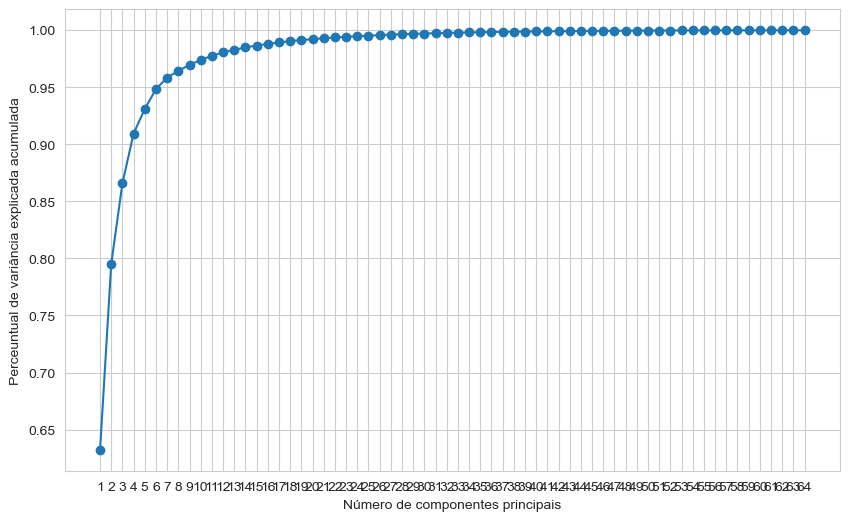

[0.631778 0.795065 0.865794 0.909456 0.931034 0.948486 0.958537 0.964468
 0.969645 0.973998 0.977691 0.980616 0.982885 0.984988 0.986651 0.988073
 0.98932  0.990505 0.991453 0.992262 0.993012 0.993724 0.994311 0.994858
 0.995353 0.995801 0.996207 0.996579 0.996916 0.997199 0.99746  0.997704
 0.997933 0.998148 0.998335 0.998502 0.998649 0.998771 0.998893 0.99901
 0.999116 0.999215 0.999302 0.99938  0.999458 0.999527 0.99959  0.999651
 0.999706 0.999755 0.999801 0.999837 0.999867 0.999896 0.999923 0.999942
 0.999958 0.99997  0.999978 0.999984 0.99999  0.999993 0.999997 1.      ] 0.9806164581489795


In [15]:
pca_channel = PCA(random_state=42,)
for event in X_train:
    pca_channel.fit(event.T)

variancia_explicada_acumulada_channel = np.cumsum(pca_channel.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_channel)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_channel, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_channel,variancia_explicada_acumulada_channel[12-1])

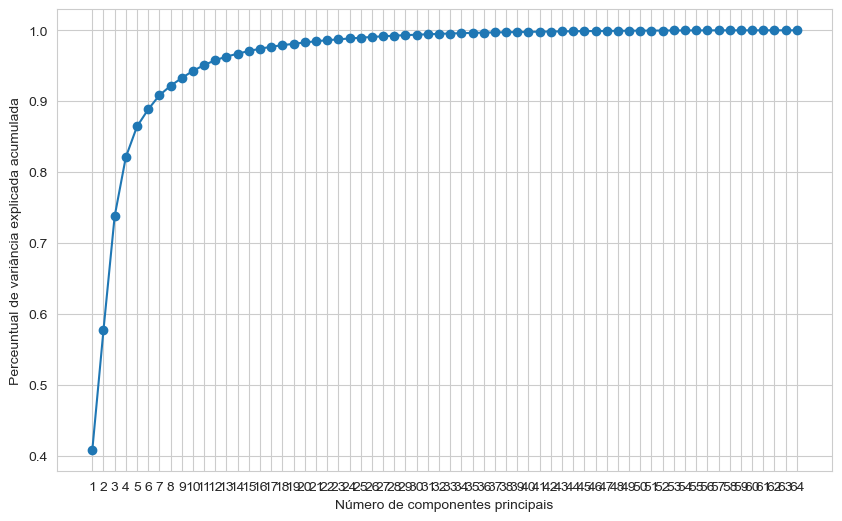

[0.408127 0.577491 0.73793  0.821288 0.864481 0.888603 0.908419 0.921795
 0.932778 0.942806 0.951039 0.957897 0.96294  0.967073 0.970853 0.974039
 0.976833 0.979066 0.980984 0.982854 0.984614 0.986014 0.98731  0.988478
 0.989613 0.99064  0.991581 0.992453 0.993183 0.993821 0.994433 0.994997
 0.995506 0.995979 0.996376 0.996736 0.997045 0.997332 0.997607 0.997858
 0.998101 0.998311 0.998515 0.998699 0.998863 0.999013 0.999158 0.999295
 0.999413 0.999521 0.999607 0.999682 0.999751 0.999815 0.999861 0.999899
 0.999929 0.999949 0.999962 0.999975 0.999984 0.999993 1.       1.      ] 0.9740393323394073


In [16]:
pca_data = PCA(random_state=42,)
for event in X_train:
    pca_data.fit(event)

variancia_explicada_acumulada_data = np.cumsum(pca_data.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_data)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_data, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_data,variancia_explicada_acumulada_data[16-1])

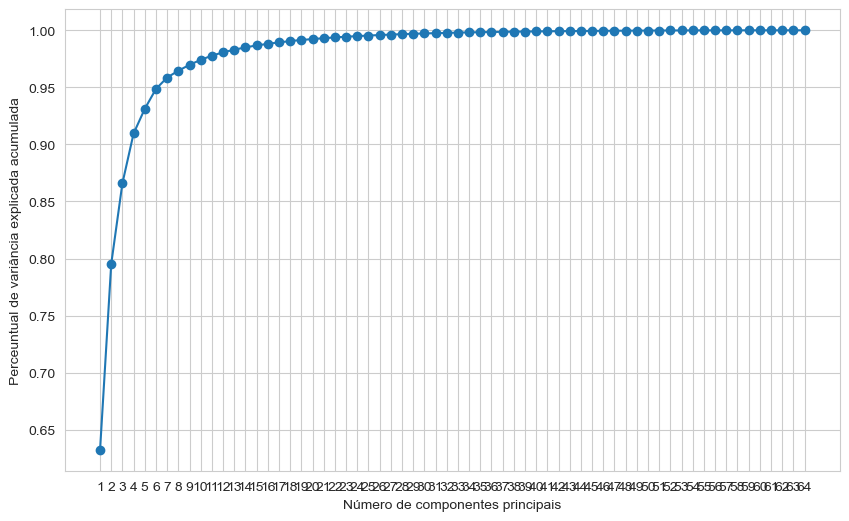

[0.631888 0.795192 0.865927 0.909568 0.931158 0.948583 0.958629 0.96457
 0.969746 0.974095 0.97778  0.980702 0.982975 0.985068 0.986731 0.988152
 0.989402 0.990577 0.991523 0.992333 0.993084 0.993788 0.994376 0.994921
 0.995413 0.995859 0.996263 0.996632 0.996965 0.997248 0.997509 0.997751
 0.997979 0.998189 0.998374 0.998539 0.998684 0.998808 0.998929 0.999044
 0.999148 0.999245 0.999331 0.99941  0.999485 0.999553 0.999616 0.999675
 0.999727 0.999776 0.999817 0.999852 0.999882 0.99991  0.999933 0.999951
 0.999965 0.999975 0.999983 0.999988 0.999993 0.999997 1.       1.      ] 0.9881519913515524


In [17]:
pca_channel_data = PCA(random_state=42,)
for event in transform_channel_per_event("X_train",pca_channel):
    pca_channel_data.fit(event)

variancia_explicada_acumulada_channel_data = np.cumsum(pca_channel_data.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_channel_data)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_channel_data, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_channel_data,variancia_explicada_acumulada_channel_data[16-1])

In [18]:
pca_all = PCA(random_state=42,)

pca_all.fit(concat_X_train)

In [ ]:

variancia_explicada_acumulada_all = np.cumsum(pca_all.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(0, len(variancia_explicada_acumulada_all)+1,100))
ax.plot(eixo_x, variancia_explicada_acumulada_all[0::100], marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_all,variancia_explicada_acumulada_all[900-1])

In [1]:
del pca_all
del pca_data
del pca_channel_data
del pca_channel


NameError: name 'pca_all' is not defined

In [2]:
del variancia_explicada_acumulada_all
del variancia_explicada_acumulada_channel
del variancia_explicada_acumulada_channel_data
del variancia_explicada_acumulada_data

NameError: name 'variancia_explicada_acumulada_all' is not defined

In [17]:
pca12_channel = PCA(random_state=42,n_components=12)
for event in X_train:
    pca12_channel.fit(event.T)

In [18]:
pca16_data = PCA(random_state=42,n_components=16)
for event in X_train:
    pca16_data.fit(event)

In [19]:
# pca900_all = PCA(random_state=42,n_components=900)
# pca900_all.fit(concat_X_train)

In [20]:
csp15 = mne.decoding.CSP(n_components=20, reg=None, log=True, norm_trace=False)
csp15.fit(X_train, y_train)


Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 9.9e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 9.9e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 20,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [21]:

csp4 = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)
csp4.fit(X_train, y_train)

Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 9.9e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0014 (2.2e-16 eps * 64 dim * 9.9e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [22]:
transform_list = []
for event in X_train:
    transform_list.append(pca12_channel.transform(event.T))
transform_list = np.stack(transform_list, axis=2) 

features_train=[]
features_test=[]
pca12_channel_fbcsps = []
freq=[4,8,12,16,20,24,28,32,36,40]
for freq_count in range(len(freq)):
    csp=mne.decoding.CSP(n_components=2, reg=None, log=True, norm_trace=False)
    lower=freq[freq_count]
    if lower==freq[-1]:
        break
    higher=freq[freq_count+1]
    X_train_filt=butter_bandpass_filter(transform_list.T,lowcut=lower,highcut=higher,fs=128,order=8)
    csp.fit(X_train_filt,y_train)
    pca12_channel_fbcsps.append(csp)


Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 12 dim * 6.3e+10  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 12 dim * 6.3e+10  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 12 dim * 3.9e+10  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 12 dim * 4e+10  max singular value)
   

In [23]:
features_train=[]
features_test=[]
fbcsps = []
freq=[4,8,12,16,20,24,28,32,36,40]
for freq_count in range(len(freq)):
    csp=mne.decoding.CSP(n_components=2, reg=None, log=True, norm_trace=False)
    lower=freq[freq_count]
    if lower==freq[-1]:
        break
    higher=freq[freq_count+1]
    X_train_filt=butter_bandpass_filter(X_train,lowcut=lower,highcut=higher,fs=128,order=8)
    csp.fit(X_train_filt,y_train)
    fbcsps.append(csp)

Computing rank from data with rank=None
    Using tolerance 0.00089 (2.2e-16 eps * 64 dim * 6.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0009 (2.2e-16 eps * 64 dim * 6.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00055 (2.2e-16 eps * 64 dim * 3.9e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00056 (2.2e-16 eps * 64 dim * 4e+10  max singular value)
   

In [24]:
transform_list = []
for event in X_train:
    transform_list.append(pca12_channel.transform(event.T))
transform_list = np.stack(transform_list, axis=2) 

pca12_channel_csp4 = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)
pca12_channel_csp4.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 0.00026 (2.2e-16 eps * 12 dim * 9.8e+10  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00026 (2.2e-16 eps * 12 dim * 9.9e+10  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [25]:
transform_list = []
for event in X_train:
    transform_list.append(pca12_channel.transform(event.T))
transform_list = np.stack(transform_list, axis=2) 

pca12_channel_csp15 = mne.decoding.CSP(n_components=20, reg=None, log=True, norm_trace=False)
pca12_channel_csp15.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 0.00026 (2.2e-16 eps * 12 dim * 9.8e+10  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00026 (2.2e-16 eps * 12 dim * 9.9e+10  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 20,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [26]:
transform_list = []
for event in X_train:
    transform_list.append(pca16_data.transform(event).T)
transform_list = np.stack(transform_list, axis=2) 

pca16_data_csp4 = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)
pca16_data_csp4.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 0.00087 (2.2e-16 eps * 64 dim * 6.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00087 (2.2e-16 eps * 64 dim * 6.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [27]:
transform_list = []
for event in X_train:
    transform_list.append(pca16_data.transform(event).T)
transform_list = np.stack(transform_list, axis=2) 

pca16_data_csp15 = mne.decoding.CSP(n_components=20, reg=None, log=True, norm_trace=False)
pca16_data_csp15.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 0.00087 (2.2e-16 eps * 64 dim * 6.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00087 (2.2e-16 eps * 64 dim * 6.1e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 20,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [28]:
# umap15_unsup = UMAP(n_components=15,random_state=42,n_neighbors=30,min_dist=0.05)
# umap15_unsup.fit(X_train[:,0,:])

In [29]:
# umap15 = UMAP(n_components=16,random_state=42,n_neighbors=30,min_dist=0.05)
# for channel in range(64):
#     umap15.fit(X_train[:,channel,:],y_train)

In [30]:
# a = umap15.transform(X_val[:,0,:])
# fig, ax = plt.subplots()
# sns.scatterplot(ax = ax, x = a[:,0],y=  a[:,1], hue =  y_val,palette="tab10")
# ax.set_ylabel("Segunda componente")
# ax.set_xlabel("Primeira Componente")
# ax.legend(["Classe","T0","T1","T2"])
# ax.set_xticks(list(range(3, 6+1))) 
# ax.set_yticks(list(range(-2, 2+1)))
# plt.show()

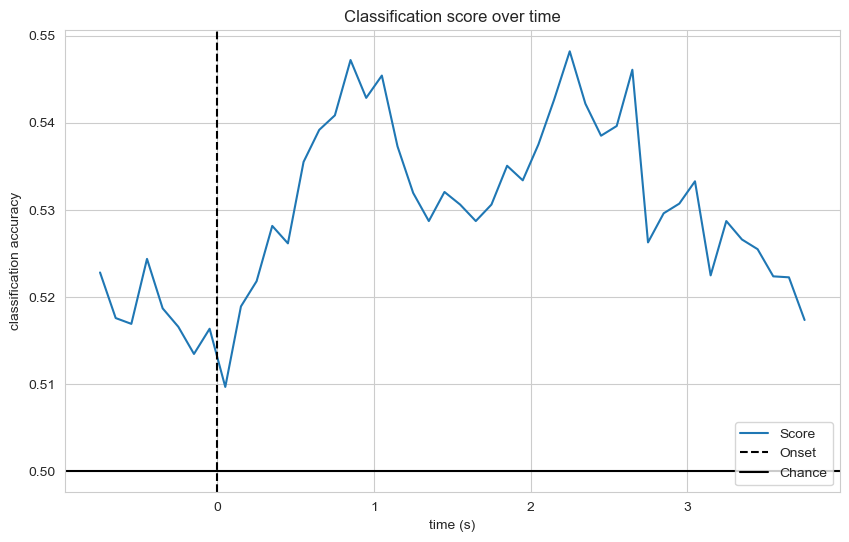

In [31]:
epochs_data_local = epochs.get_data()
epochs_data_train_local = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train_local)
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data_local.shape[2] - w_length, w_step)
lda = LinearDiscriminantAnalysis()

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train_local, y_test_local = labels[train_idx], labels[test_idx]

    X_train_local = csp4.transform(epochs_data_train_local[train_idx])

    # fit classifier
    lda.fit(X_train_local, y_train_local)

cv_split = cv.split(epochs_data_train_local)

for train_idx, test_idx in cv_split:
    y_train_local, y_test_local = labels[train_idx], labels[test_idx]
    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test_local = csp4.transform(epochs_data_local[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test_local, y_test_local))
    scores_windows.append(score_this_window)


# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [32]:
import numpy as np

class Classifier:
    def __init__(self,model,FeatureSelectModel=None):
        self.model = model
        self.feature_selection = False
        self.FeatureSelectModel = FeatureSelectModel

    def predict(self,x_features):
        if self.feature_selection:
            x_features_selected = self.feature_selection.transform(x_features)
        else:
            x_features_selected = x_features
        y_predicted = self.model.predict(x_features_selected)
        return y_predicted

    def fit(self,x_features,y_train):
        feature_selection = True
        if feature_selection:
            if self.FeatureSelectModel is None:
                self.feature_selection = FeatureSelect()
            else:
                self.feature_selection = self.FeatureSelectModel
            
            x_train_features_selected = self.feature_selection.fit_transform(x_features,y_train)
        else:
            x_train_features_selected = x_features
        self.model.fit(x_train_features_selected,y_train)
        y_predicted = self.model.predict(x_train_features_selected)
        return y_predicted
    
    def score(self, x_test, y_test):
        y_predicted = self.predict(x_test)
        return accuracy_score(y_test, y_predicted)

class FeatureSelect:
    def __init__(self, n_features_select=4, n_csp_pairs=2):
        self.n_features_select = n_features_select
        self.n_csp_pairs = n_csp_pairs
        self.features_selected_indices=[]

    def fit_transform(self,x_train_features,y_train):
        MI_features = self.MIBIF(x_train_features, y_train)
        MI_sorted_idx = np.argsort(MI_features)[::-1]
        features_selected = MI_sorted_idx[:self.n_features_select]

        paired_features_idx = self.select_CSP_pairs(features_selected, self.n_csp_pairs)
        x_train_features_selected = x_train_features[:, paired_features_idx]
        self.features_selected_indices = paired_features_idx

        return x_train_features_selected

    def transform(self,x_test_features):
        return x_test_features[:,self.features_selected_indices]

    def MIBIF(self, x_features, y_labels):
        def get_prob_pw(x,d,i,h):
            n_data = d.shape[0]
            t=d[:,i]
            kernel = lambda u: np.exp(-0.5*(u**2))/np.sqrt(2*np.pi)
            prob_x = 1 / (n_data * h) * sum(kernel((np.ones((len(t)))*x- t)/h))
            return prob_x

        def get_pd_pw(d, i, x_trials):
            n_data, n_dimensions = d.shape
            if n_dimensions==1:
                i=1
            t = d[:,i]
            min_x = np.min(t)
            max_x = np.max(t)
            n_trials = x_trials.shape[0]
            std_t = np.std(t)
            if std_t==0:
                h=0.005
            else:
                h=(4./(3*n_data))**(0.2)*std_t
            prob_x = np.zeros((n_trials))
            for j in range(n_trials):
                prob_x[j] = get_prob_pw(x_trials[j],d,i,h)
            return prob_x, x_trials, h

        y_classes = np.unique(y_labels)
        n_classes = len(y_classes)
        n_trials = len(y_labels)
        prob_w = []
        x_cls = {}
        for i in range(n_classes):
            cls = y_classes[i]
            cls_indx = np.where(y_labels == cls)[0]
            prob_w.append(len(cls_indx) / n_trials)
            x_cls.update({i: x_features[cls_indx, :]})

        prob_x_w = np.zeros((n_classes, n_trials, x_features.shape[1]))
        prob_w_x = np.zeros((n_classes, n_trials, x_features.shape[1]))
        h_w_x = np.zeros((x_features.shape[1]))
        mutual_info = np.zeros((x_features.shape[1]))
        parz_win_width = 1.0 / np.log2(n_trials)
        h_w = -np.sum(prob_w * np.log2(prob_w))

        for i in range(x_features.shape[1]):
            h_w_x[i] = 0
            for j in range(n_classes):
                prob_x_w[j, :, i] = get_pd_pw(x_cls.get(j), i, x_features[:, i])[0]

        t_s = prob_x_w.shape
        n_prob_w_x = np.zeros((n_classes, t_s[1], t_s[2]))
        for i in range(n_classes):
            n_prob_w_x[i, :, :] = prob_x_w[i] * prob_w[i]
        prob_x = np.sum(n_prob_w_x, axis=0)
        # prob_w_x = np.zeros((n_classes, prob_x.shape[0], prob_w.shape[1]))
        for i in range(n_classes):
            prob_w_x[i, :, :] = n_prob_w_x[i, :, :]/prob_x

        for i in range(x_features.shape[1]):
            for j in range(n_trials):
                t_sum = 0.0
                for k in range(n_classes):
                    if prob_w_x[k, j, i] > 0:
                        t_sum += (prob_w_x[k, j, i] * np.log2(prob_w_x[k, j, i]))

                h_w_x[i] -= (t_sum / n_trials)

            mutual_info[i] = h_w - h_w_x[i]

        mifsg = np.asarray(mutual_info)
        return mifsg


    def select_CSP_pairs(self,features_selected,n_pairs):
        features_selected+=1
        sel_groups = np.unique(np.ceil(features_selected/n_pairs))
        paired_features = []
        for i in range(len(sel_groups)):
            for j in range(n_pairs-1,-1,-1):
                paired_features.append(sel_groups[i]*n_pairs-j)

        paired_features = np.asarray(paired_features,dtype=np.int)-1
        print(paired_features)
        return paired_features
        


In [ ]:
#Get Indices (it's the same for all, as suffle is False by default)
pipe = Pipe("lda_fbcsp",Classifier(LinearDiscriminantAnalysis()),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps"))

pipeline = pipe.create_pipeline()
cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True,return_indices=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

print(f"Results for pipeline with {pipe.name}:")
print("----------------")
print("Test accuracy scores:", cv_results['test_Accuracy'])
print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
print("-----")
print("Test F1 scores:", cv_results['test_F1'])
print("Mean test F1:", cv_results['test_F1'].mean())
print("----------------")
print("train accuracy scores:", cv_results['train_Accuracy'])
print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
print("-----")
print("train F1 scores:", cv_results['train_F1'])
print("Mean train F1:", cv_results['train_F1'].mean())
print("----------------")
print("Fit time:", cv_results['fit_time'])
print("Score time:", cv_results['score_time'])
print()
print("--------------------------------------------------------------------------------------------")

indices = cv_results["indices"]["test"]

In [33]:
def aff(array):
    X_std = (array - np.min(array)) / (np.max(array) - np.min(array))
    X_scaled = X_std * (1-0)+0
    return X_scaled

### Not runned MLP

In [ ]:
# # MLP_plain = Pipe("MLP_plain",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),concat_channels("X_train")) - Takes too long
# MLP_csp4 = Pipe("MLP_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
# MLP_csp15 = Pipe("MLP_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
# MLP_pca12_channel = Pipe("MLP_pca12_channel",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
# MLP_pca16_data = Pipe("MLP_pca16_data",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# # # # # MLP_pca900_all = Pipe("MLP_pca900_all",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
# MLP_pca12_channel_csp4 = Pipe("MLP_pca12_channel_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
# MLP_pca16_data_csp4 = Pipe("MLP_pca16_data_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# MLP_pca12_channel_csp15 = Pipe("MLP_pca12_channel_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
# MLP_pca16_data_csp15 = Pipe("MLP_pca16_data_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# Keras_MLP_csp4 = Pipe("Keras_MLP_csp4",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp4).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
# Keras_MLP_csp15 = Pipe("Keras_MLP_csp15",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp15).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp15),transform_csp("X_val",csp15))

# Keras_MLP_pca12_channel = Pipe("Keras_MLP_pca12_channel",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_concat("X_train",pca12_channel).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
# Keras_MLP_pca16_data = Pipe("Keras_MLP_pca16_data",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_concat("X_train",pca16_data).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# # # Keras_MLP_pca900_all = Pipe("Keras_MLP_pca900_all",KerasClassifier(model=create_model, my_params={
#         # "layers":[
#         #     # tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_all_concat("X_train",pca900_all).shape[1],)),
#         #     tf.keras.layers.Dense(20, activation='sigmoid'),
#         #     tf.keras.layers.Dropout(0.5,seed= 42),
#         #     tf.keras.layers.Dense(20, activation='sigmoid'),
#         #     tf.keras.layers.Dropout(0.5,seed= 42),
#         #     tf.keras.layers.Dense(10, activation='sigmoid'),
#         #     tf.keras.layers.Dense(5, activation='sigmoid'),
#         #     tf.keras.layers.Dense(3, activation='softmax')
#         # ],
#         # "optimizer":'adam',
#         # "loss": 'sparse_categorical_crossentropy',
#         # "metrics": ['accuracy']
#     # # }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))



# Keras_MLP_pca16_data_csp4 = Pipe("Keras_MLP_pca16_data_csp4",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# Keras_MLP_pca12_channel_csp4 = Pipe("Keras_MLP_pca12_channel_csp4",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
# Keras_MLP_pca16_data_csp15 = Pipe("Keras_MLP_pca16_data_csp15",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# Keras_MLP_pca12_channel_csp15 = Pipe("Keras_MLP_pca12_channel_csp15",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))



### Runned Models

In [34]:
lda_pca12_channel = Pipe("lda_pca12_channel",LinearDiscriminantAnalysis(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
lda_csp4 = Pipe("lda_csp4",LinearDiscriminantAnalysis(),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
lda_pca12_channel_csp4 = Pipe("lda_pca12_channel_csp4",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
lda_csp15 = Pipe("lda_csp15",LinearDiscriminantAnalysis(),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
lda_pca12_channel_csp15 = Pipe("lda_pca12_channel_csp15",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
lda_fbcsp = Pipe("lda_fbcsp",LinearDiscriminantAnalysis(),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps"))
lda_fbcsp_pca12_channel = Pipe("lda_fbcsp_pca12_channel",LinearDiscriminantAnalysis(),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel))



lda_pca12_channel_with_MIBIF = Pipe("lda_pca12_channel_with_MIBIF",Classifier(LinearDiscriminantAnalysis()),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
# lda_csp4_with_MIBIF = Pipe("lda_csp4_with_MIBIF",Classifier(LinearDiscriminantAnalysis()),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
lda_pca12_channel_csp4_with_MIBIF = Pipe("lda_pca12_channel_csp4_with_MIBIF",Classifier(LinearDiscriminantAnalysis()),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
lda_csp15_with_MIBIF = Pipe("lda_csp15_with_MIBIF",Classifier(LinearDiscriminantAnalysis()),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
lda_pca12_channel_csp15_with_MIBIF = Pipe("lda_pca12_channel_csp15_with_MIBIF",Classifier(LinearDiscriminantAnalysis()),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
lda_fbcsp_with_MIBIF = Pipe("lda_fbcsp_with_MIBIF",Classifier(LinearDiscriminantAnalysis()),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps"))
lda_fbcsp_pca12_channel_with_MIBIF = Pipe("lda_fbcsp_pca12_channel_with_MIBIF",Classifier(LinearDiscriminantAnalysis()),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel))


parzen_window_mnbc_pca12_channel = Pipe("parzen_window_mnbc_pca12_channel",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
parzen_window_mnbc_csp4 = Pipe("parzen_window_mnbc_csp4",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
parzen_window_mnbc_pca12_channel_csp4 = Pipe("parzen_window_mnbc_pca12_channel_csp4",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
parzen_window_mnbc_csp15 = Pipe("parzen_window_mnbc_csp15",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
parzen_window_mnbc_pca12_channel_csp15 = Pipe("parzen_window_mnbc_pca12_channel_csp15",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
parzen_window_mnbc_fbcsp = Pipe("parzen_window_mnbc_fbcsp",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )
parzen_window_mnbc_fbcsp_pca12_channel = Pipe("parzen_window_mnbc_fbcsp_pca12_channel",NaiveBayesClassifier(bandwidth=4,kernel='radial'),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )

parzen_window_mnbc_pca12_channel_with_MIBIF = Pipe("parzen_window_mnbc_pca12_channel_with_MIBIF",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
parzen_window_mnbc_csp4_with_MIBIF = Pipe("parzen_window_mnbc_csp4_with_MIBIF",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
parzen_window_mnbc_pca12_channel_csp4_with_MIBIF = Pipe("parzen_window_mnbc_pca12_channel_csp4_with_MIBIF",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
parzen_window_mnbc_csp15_with_MIBIF = Pipe("parzen_window_mnbc_csp15_with_MIBIF",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
parzen_window_mnbc_pca12_channel_csp15_with_MIBIF = Pipe("parzen_window_mnbc_pca12_channel_csp15_with_MIBIF",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
parzen_window_mnbc_fbcsp_with_MIBIF = Pipe("parzen_window_mnbc_fbcsp_with_MIBIF",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )
parzen_window_mnbc_fbcsp_pca12_channel_with_MIBIF = Pipe("parzen_window_mnbc_fbcsp_pca12_channel_with_MIBIF",Classifier(NaiveBayesClassifier(bandwidth=4,kernel='radial')),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )



svm_pca12_channel = Pipe("svm_pca12_channel",SVC(C=1,kernel='rbf'),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
svm_csp4 = Pipe("svm_csp4",SVC(C=1,kernel='rbf'),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
svm_pca12_channel_csp4 = Pipe("svm_pca12_channel_csp4",SVC(C=1,kernel='rbf'),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
svm_csp15 = Pipe("svm_csp15",SVC(C=1,kernel='rbf'),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
svm_pca12_channel_csp15 = Pipe("svm_pca12_channel_csp15",SVC(C=1,kernel='rbf'),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
svm_fbcsp = Pipe("svm_fbcsp",SVC(C=1,kernel='rbf'),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )
svm_fbcsp_pca12_channel = Pipe("svm_fbcsp_pca12_channel",SVC(C=1,kernel='rbf'),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )



svm_pca12_channel_with_MIBIF = Pipe("svm_pca12_channel_with_MIBIF",Classifier(SVC(C=1,kernel='rbf')),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
svm_csp4_with_MIBIF = Pipe("svm_csp4_with_MIBIF",Classifier(SVC(C=1,kernel='rbf')),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
svm_pca12_channel_csp4_with_MIBIF = Pipe("svm_pca12_channel_csp4_with_MIBIF",Classifier(SVC(C=1,kernel='rbf')),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
svm_csp15_with_MIBIF = Pipe("svm_csp15_with_MIBIF",Classifier(SVC(C=1,kernel='rbf')),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
svm_pca12_channel_csp15_with_MIBIF = Pipe("svm_pca12_channel_csp15_with_MIBIF",Classifier(SVC(C=1,kernel='rbf')),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
svm_fbcsp_with_MIBIF = Pipe("svm_fbcsp_with_MIBIF",Classifier(SVC(C=1,kernel='rbf')),transform_FBCSP("X_train","fbcsps"),transform_FBCSP("X_val","fbcsps") )
svm_fbcsp_pca12_channel_with_MIBIF = Pipe("svm_fbcsp_pca12_channel_with_MIBIF",Classifier(SVC(C=1,kernel='rbf')),transform_FBCSP_channel("X_train","pca12_channel_fbcsps",pca12_channel),transform_FBCSP_channel("X_val","pca12_channel_fbcsps",pca12_channel) )


Pipes= [
lda_pca12_channel,
lda_csp4,
lda_pca12_channel_csp4,
lda_csp15,
lda_pca12_channel_csp15,
lda_fbcsp,
lda_fbcsp_pca12_channel,
# lda_pca12_channel_with_MIBIF,
# lda_csp4_with_MIBIF,
# lda_pca12_channel_csp4_with_MIBIF,
# lda_csp15_with_MIBIF,
# lda_pca12_channel_csp15_with_MIBIF,
lda_fbcsp_with_MIBIF,
lda_fbcsp_pca12_channel_with_MIBIF,
parzen_window_mnbc_pca12_channel,
parzen_window_mnbc_csp4,
parzen_window_mnbc_pca12_channel_csp4,
parzen_window_mnbc_csp15,
parzen_window_mnbc_pca12_channel_csp15,
parzen_window_mnbc_fbcsp,
# parzen_window_mnbc_fbcsp_pca12_channel,
# parzen_window_mnbc_pca12_channel_with_MIBIF,
# parzen_window_mnbc_csp4_with_MIBIF,
# parzen_window_mnbc_pca12_channel_csp4_with_MIBIF,
# parzen_window_mnbc_csp15_with_MIBIF,
# parzen_window_mnbc_pca12_channel_csp15_with_MIBIF,
parzen_window_mnbc_fbcsp_with_MIBIF,
parzen_window_mnbc_fbcsp_pca12_channel_with_MIBIF,
svm_pca12_channel,
svm_csp4,
svm_pca12_channel_csp4,
svm_csp15,
svm_pca12_channel_csp15,
svm_fbcsp,
svm_fbcsp_pca12_channel,
# svm_pca12_channel_with_MIBIF,
# svm_csp4_with_MIBIF,
# svm_pca12_channel_csp4_with_MIBIF,
# svm_csp15_with_MIBIF,
# svm_pca12_channel_csp15_with_MIBIF,
svm_fbcsp_with_MIBIF,
svm_fbcsp_pca12_channel_with_MIBIF,   
]


In [ ]:
results = {}
for pipe in Pipes:
    print(pipe.name)
    # Create pipeline with the given pipe
    pipeline = pipe.create_pipeline()
    
    # Perform cross-validation
    cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

    print(f"Results for pipeline with {pipe.name}:")
    print("----------------")
    print("Test accuracy scores:", cv_results['test_Accuracy'])
    print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
    print("-----")
    print("Test F1 scores:", cv_results['test_F1'])
    print("Mean test F1:", cv_results['test_F1'].mean())
    print("----------------")
    print("train accuracy scores:", cv_results['train_Accuracy'])
    print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
    print("-----")
    print("train F1 scores:", cv_results['train_F1'])
    print("Mean train F1:", cv_results['train_F1'].mean())
    print("----------------")
    print("Fit time:", cv_results['fit_time'])
    print("Score time:", cv_results['score_time'])
    print()
    print("--------------------------------------------------------------------------------------------")

    results[pipe.name] = (cv_results)


In [ ]:
for key, value in results.items(): 
    print(value['test_Accuracy'])
    print(",")
for key, value in results.items(): 
    print(np.mean(value['test_Accuracy']))
    print(",")
for key, value in results.items(): 
    print(np.max(value['test_Accuracy']))
    print(",")
for key, value in results.items(): 
    print(value['test_F1'])
    print(",")
for key, value in results.items(): 
    print(value['train_Accuracy'])
    print(",")
for key, value in results.items(): 
    print(np.mean(value['train_Accuracy']))
    print(",")
for key, value in results.items(): 
    print(np.max(value['train_Accuracy']))
    print(",")
for key, value in results.items(): 
    print(value['train_F1'])
    print(",")
for key, value in results.items(): 
    print(value['fit_time'])
    print(",")
for key, value in results.items(): 
    print(value['score_time'])
    print(",")

In [35]:
results_val = {}
for pipe in Pipes:
    print(pipe.name)
    # Create pipeline with the given pipe
    pipeline = pipe.create_pipeline()
    
    # Perform cross-validation
    pipeline.fit( pipe.processed_X_train, y_train)
    train_score = pipeline.score(pipe.processed_X_train,y_train)
    val_score = pipeline.score(pipe.processed_X_val,y_val)


    print(f"Results for pipeline with {pipe.name}:")
    print("----------------")
    print("Test accuracy scores:", val_score)
    print("----------------")
    print("train accuracy scores:", train_score)
    print()
    print("--------------------------------------------------------------------------------------------")

    results_val[pipe.name] = (pipeline)


lda_pca12_channel
Results for pipeline with lda_pca12_channel:
----------------
Test accuracy scores: 0.5219005196733482
----------------
train accuracy scores: 0.9780394653087205

--------------------------------------------------------------------------------------------
lda_csp4
Results for pipeline with lda_csp4:
----------------
Test accuracy scores: 0.5278396436525612
----------------
train accuracy scores: 0.5273711012094208

--------------------------------------------------------------------------------------------
lda_pca12_channel_csp4
Results for pipeline with lda_pca12_channel_csp4:
----------------
Test accuracy scores: 0.5634743875278396
----------------
train accuracy scores: 0.5786123488224061

--------------------------------------------------------------------------------------------
lda_csp15
Results for pipeline with lda_csp15:
----------------
Test accuracy scores: 0.5493689680772086
----------------
train accuracy scores: 0.5957988542329726

---------------------

C:\Users\Vinícius\AppData\Local\Temp\ipykernel_1448\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[2 3 4 5 6 7]
Results for pipeline with lda_fbcsp_with_MIBIF:
----------------
Test accuracy scores: 0.5686711210096511
----------------
train accuracy scores: 0.6222151495862508

--------------------------------------------------------------------------------------------
lda_fbcsp_pca12_channel_with_MIBIF


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_1448\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[ 2  3  8  9 14 15]
Results for pipeline with lda_fbcsp_pca12_channel_with_MIBIF:
----------------
Test accuracy scores: 0.5567928730512249
----------------
train accuracy scores: 0.586569064290261

--------------------------------------------------------------------------------------------
parzen_window_mnbc_pca12_channel


d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return summation / (N * (h ** dim))


Results for pipeline with parzen_window_mnbc_pca12_channel:
----------------
Test accuracy scores: 0.5003711952487008
----------------
train accuracy scores: 0.5012730744748568

--------------------------------------------------------------------------------------------
parzen_window_mnbc_csp4
Results for pipeline with parzen_window_mnbc_csp4:
----------------
Test accuracy scores: 0.5270972531551597
----------------
train accuracy scores: 0.5171865054105665

--------------------------------------------------------------------------------------------
parzen_window_mnbc_pca12_channel_csp4
Results for pipeline with parzen_window_mnbc_pca12_channel_csp4:
----------------
Test accuracy scores: 0.5352635486265775
----------------
train accuracy scores: 0.5286441756842776

--------------------------------------------------------------------------------------------
parzen_window_mnbc_csp15


d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  return summation / (N * (h ** dim))


Results for pipeline with parzen_window_mnbc_csp15:
----------------
Test accuracy scores: 0.5003711952487008
----------------
train accuracy scores: 0.5012730744748568

--------------------------------------------------------------------------------------------
parzen_window_mnbc_pca12_channel_csp15


d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: overflow encountered in long_scalars
  return summation / (N * (h ** dim))


Results for pipeline with parzen_window_mnbc_pca12_channel_csp15:
----------------
Test accuracy scores: 0.49962880475129917
----------------
train accuracy scores: 0.4987269255251432

--------------------------------------------------------------------------------------------
parzen_window_mnbc_fbcsp
Results for pipeline with parzen_window_mnbc_fbcsp:
----------------
Test accuracy scores: 0.5003711952487008
----------------
train accuracy scores: 0.5012730744748568

--------------------------------------------------------------------------------------------
parzen_window_mnbc_fbcsp_with_MIBIF


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_1448\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[2 3 4 5 6 7]
Results for pipeline with parzen_window_mnbc_fbcsp_with_MIBIF:
----------------
Test accuracy scores: 0.5642167780252413
----------------
train accuracy scores: 0.6069382558879695

--------------------------------------------------------------------------------------------
parzen_window_mnbc_fbcsp_pca12_channel_with_MIBIF


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_1448\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[ 2  3  8  9 14 15]
Results for pipeline with parzen_window_mnbc_fbcsp_pca12_channel_with_MIBIF:
----------------
Test accuracy scores: 0.5575352635486266
----------------
train accuracy scores: 0.549013367281986

--------------------------------------------------------------------------------------------
svm_pca12_channel
Results for pipeline with svm_pca12_channel:
----------------
Test accuracy scores: 0.4951744617668894
----------------
train accuracy scores: 0.8459579885423297

--------------------------------------------------------------------------------------------
svm_csp4
Results for pipeline with svm_csp4:
----------------
Test accuracy scores: 0.5315515961395694
----------------
train accuracy scores: 0.5464672183322724

--------------------------------------------------------------------------------------------
svm_pca12_channel_csp4
Results for pipeline with svm_pca12_channel_csp4:
----------------
Test accuracy scores: 0.5642167780252413
----------------
train accuracy 

C:\Users\Vinícius\AppData\Local\Temp\ipykernel_1448\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[2 3 4 5 6 7]
Results for pipeline with svm_fbcsp_with_MIBIF:
----------------
Test accuracy scores: 0.5738678544914625
----------------
train accuracy scores: 0.6378103119032463

--------------------------------------------------------------------------------------------
svm_fbcsp_pca12_channel_with_MIBIF


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_1448\810490552.py:137: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  paired_features = np.asarray(paired_features,dtype=np.int)-1


[ 2  3  8  9 14 15]
Results for pipeline with svm_fbcsp_pca12_channel_with_MIBIF:
----------------
Test accuracy scores: 0.5553080920564217
----------------
train accuracy scores: 0.6015276893698281

--------------------------------------------------------------------------------------------


lda_pca12_channel
              precision    recall  f1-score   support

           0     0.5211    0.5490    0.5347       674
           1     0.5228    0.4948    0.5084       673

    accuracy                         0.5219      1347
   macro avg     0.5219    0.5219    0.5215      1347
weighted avg     0.5219    0.5219    0.5215      1347



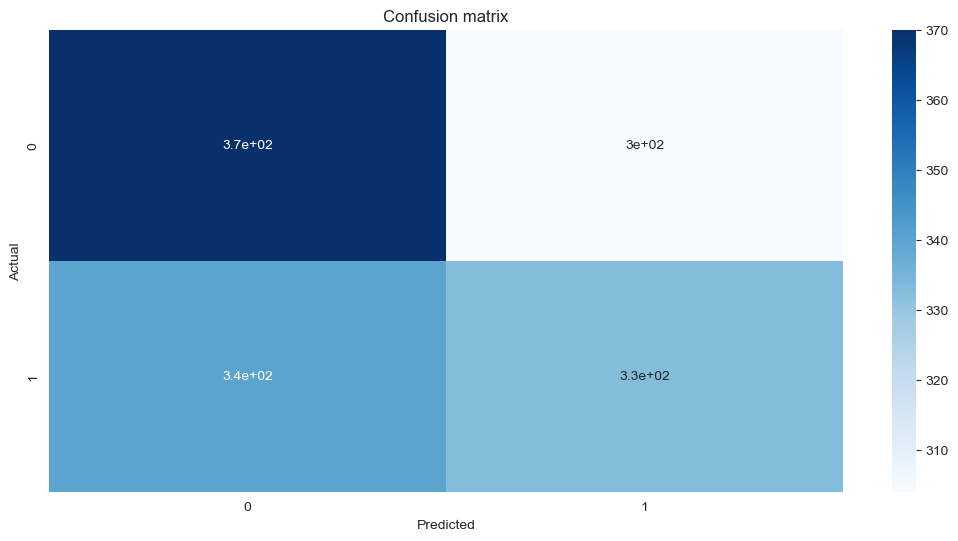

lda_csp4
              precision    recall  f1-score   support

           0     0.5257    0.5757    0.5496       674
           1     0.5304    0.4799    0.5039       673

    accuracy                         0.5278      1347
   macro avg     0.5281    0.5278    0.5267      1347
weighted avg     0.5281    0.5278    0.5268      1347



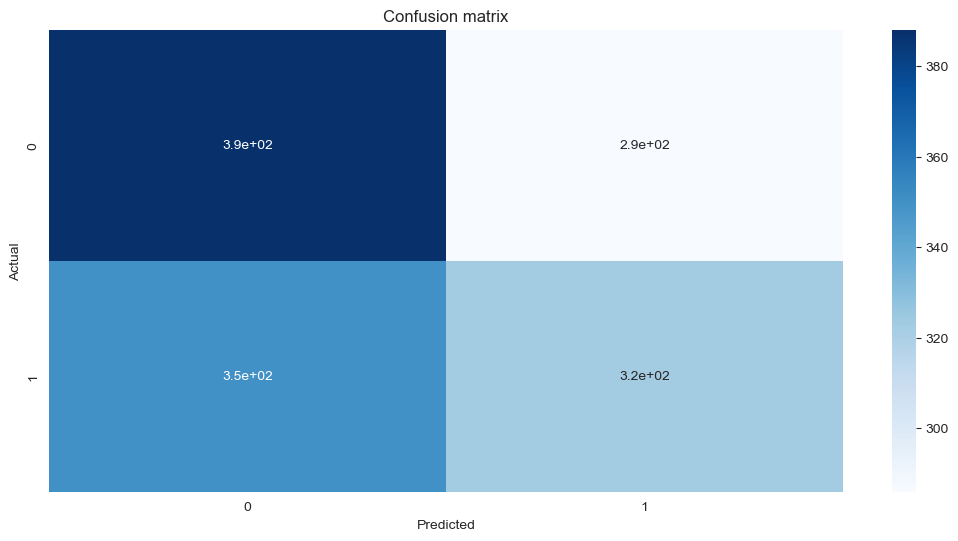

lda_pca12_channel_csp4
              precision    recall  f1-score   support

           0     0.5712    0.5119    0.5399       674
           1     0.5572    0.6152    0.5847       673

    accuracy                         0.5635      1347
   macro avg     0.5642    0.5635    0.5623      1347
weighted avg     0.5642    0.5635    0.5623      1347



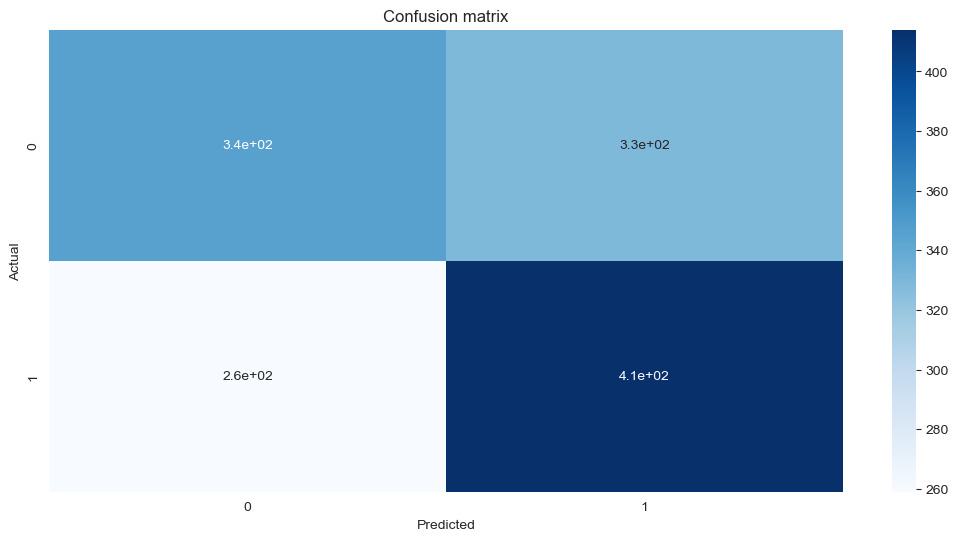

lda_csp15
              precision    recall  f1-score   support

           0     0.5534    0.5148    0.5334       674
           1     0.5458    0.5840    0.5642       673

    accuracy                         0.5494      1347
   macro avg     0.5496    0.5494    0.5488      1347
weighted avg     0.5496    0.5494    0.5488      1347



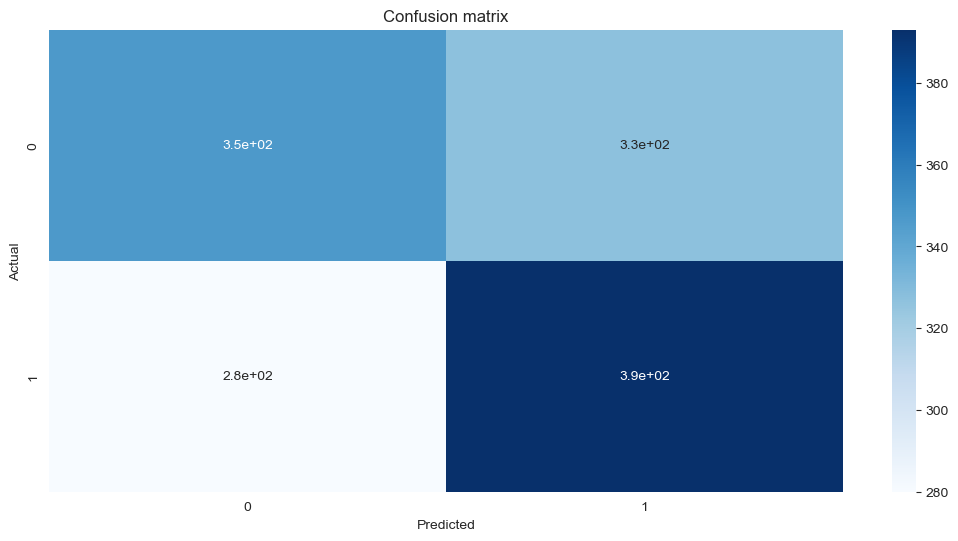

lda_pca12_channel_csp15
              precision    recall  f1-score   support

           0     0.5669    0.5282    0.5469       674
           1     0.5577    0.5958    0.5761       673

    accuracy                         0.5620      1347
   macro avg     0.5623    0.5620    0.5615      1347
weighted avg     0.5623    0.5620    0.5615      1347



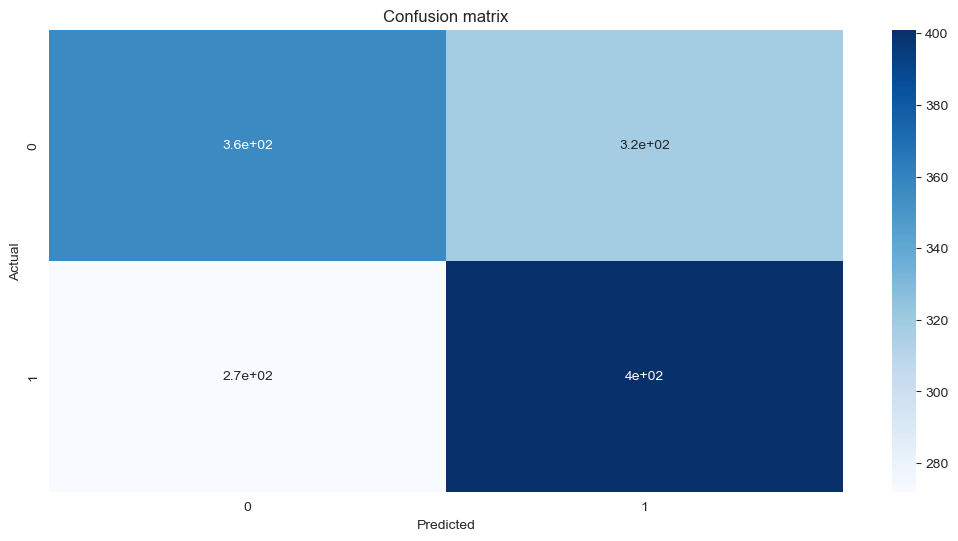

lda_fbcsp
              precision    recall  f1-score   support

           0     0.5656    0.4733    0.5153       674
           1     0.5466    0.6360    0.5879       673

    accuracy                         0.5546      1347
   macro avg     0.5561    0.5546    0.5516      1347
weighted avg     0.5561    0.5546    0.5516      1347



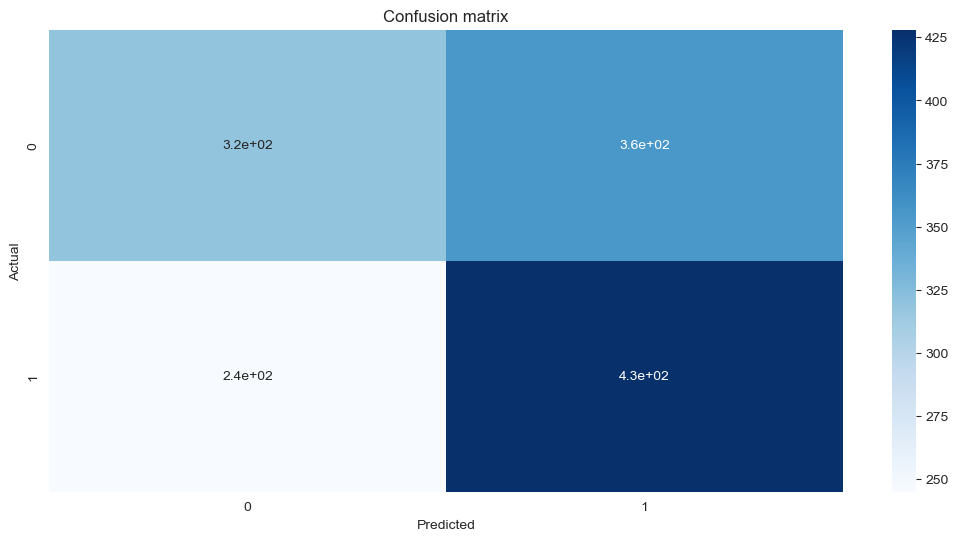

lda_fbcsp_pca12_channel
              precision    recall  f1-score   support

           0     0.5686    0.5104    0.5379       674
           1     0.5553    0.6122    0.5823       673

    accuracy                         0.5612      1347
   macro avg     0.5619    0.5613    0.5601      1347
weighted avg     0.5619    0.5612    0.5601      1347



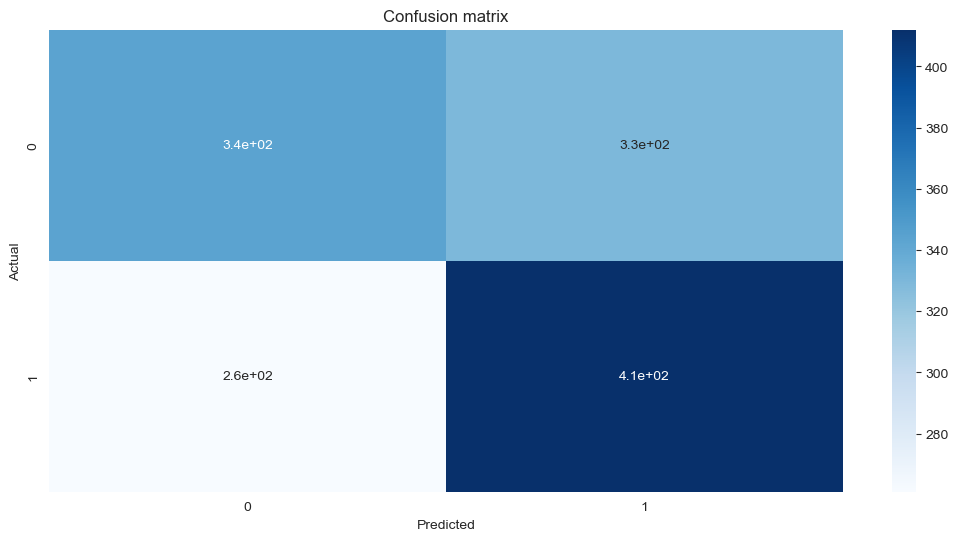

lda_fbcsp_with_MIBIF
              precision    recall  f1-score   support

           0     0.5814    0.4926    0.5333       674
           1     0.5593    0.6449    0.5990       673

    accuracy                         0.5687      1347
   macro avg     0.5704    0.5687    0.5662      1347
weighted avg     0.5704    0.5687    0.5662      1347



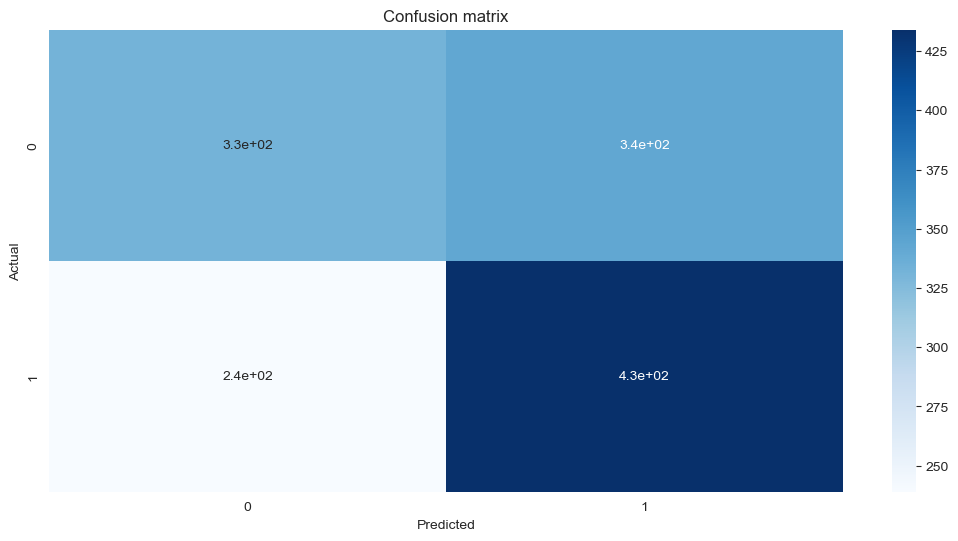

lda_fbcsp_pca12_channel_with_MIBIF
              precision    recall  f1-score   support

           0     0.5649    0.4970    0.5288       674
           1     0.5504    0.6166    0.5816       673

    accuracy                         0.5568      1347
   macro avg     0.5577    0.5568    0.5552      1347
weighted avg     0.5577    0.5568    0.5552      1347



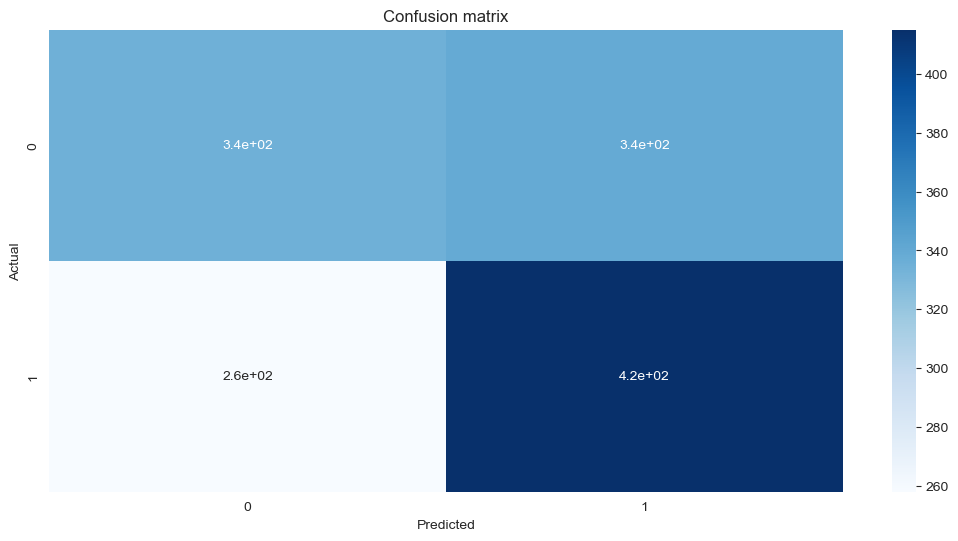

parzen_window_mnbc_pca12_channel


d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return summation / (N * (h ** dim))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defin

              precision    recall  f1-score   support

           0     0.5004    1.0000    0.6670       674
           1     0.0000    0.0000    0.0000       673

    accuracy                         0.5004      1347
   macro avg     0.2502    0.5000    0.3335      1347
weighted avg     0.2504    0.5004    0.3337      1347



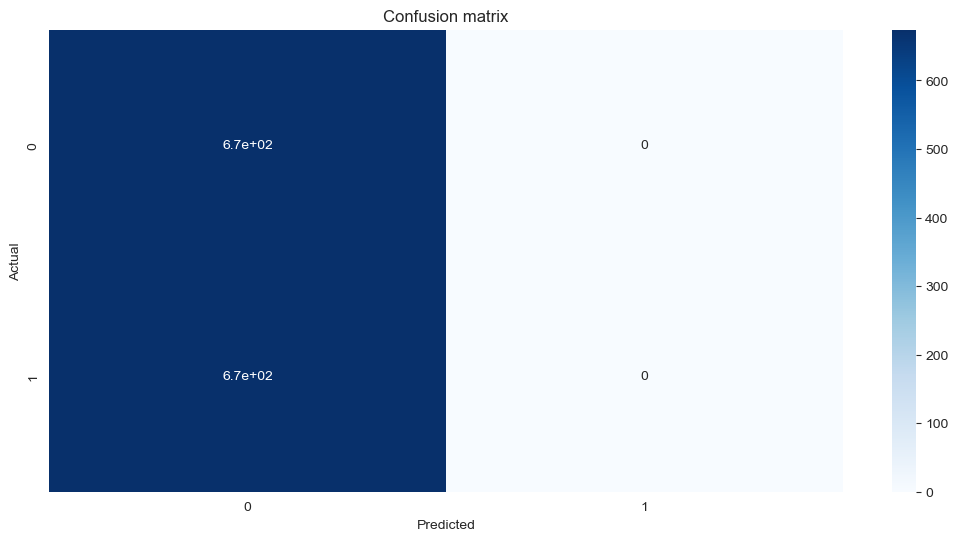

parzen_window_mnbc_csp4
              precision    recall  f1-score   support

           0     0.5249    0.5786    0.5505       674
           1     0.5298    0.4755    0.5012       673

    accuracy                         0.5271      1347
   macro avg     0.5274    0.5271    0.5258      1347
weighted avg     0.5273    0.5271    0.5258      1347



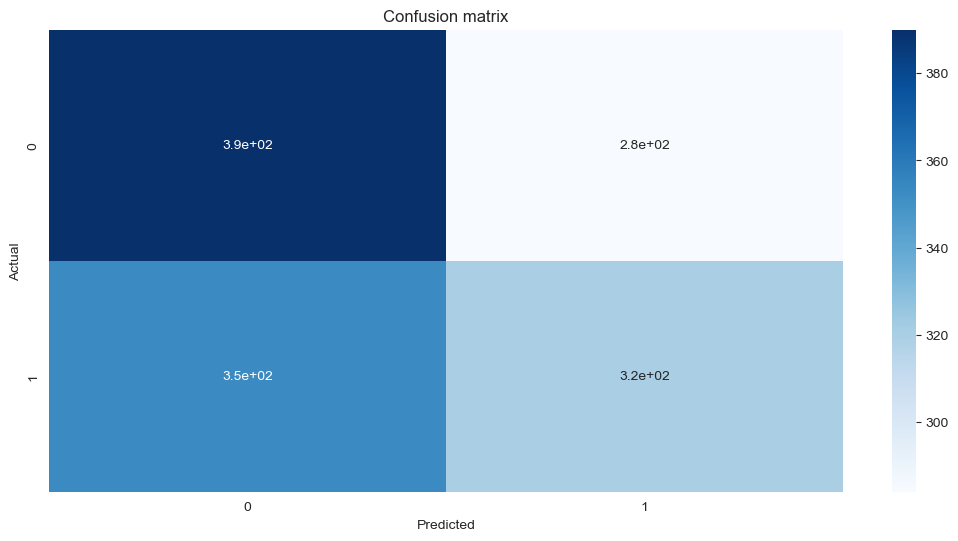

parzen_window_mnbc_pca12_channel_csp4
              precision    recall  f1-score   support

           0     0.5364    0.5252    0.5307       674
           1     0.5342    0.5453    0.5397       673

    accuracy                         0.5353      1347
   macro avg     0.5353    0.5353    0.5352      1347
weighted avg     0.5353    0.5353    0.5352      1347



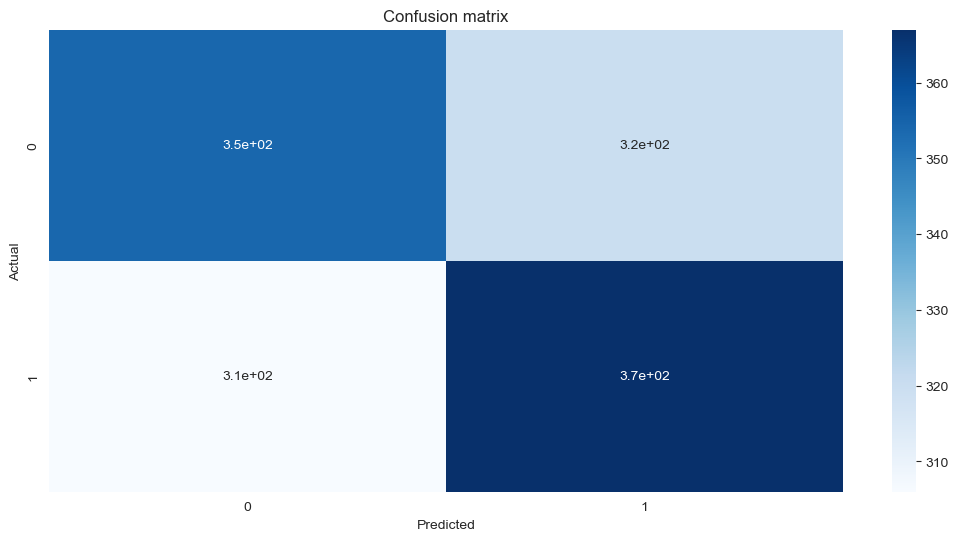

parzen_window_mnbc_csp15


d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  return summation / (N * (h ** dim))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defi

              precision    recall  f1-score   support

           0     0.5004    1.0000    0.6670       674
           1     0.0000    0.0000    0.0000       673

    accuracy                         0.5004      1347
   macro avg     0.2502    0.5000    0.3335      1347
weighted avg     0.2504    0.5004    0.3337      1347



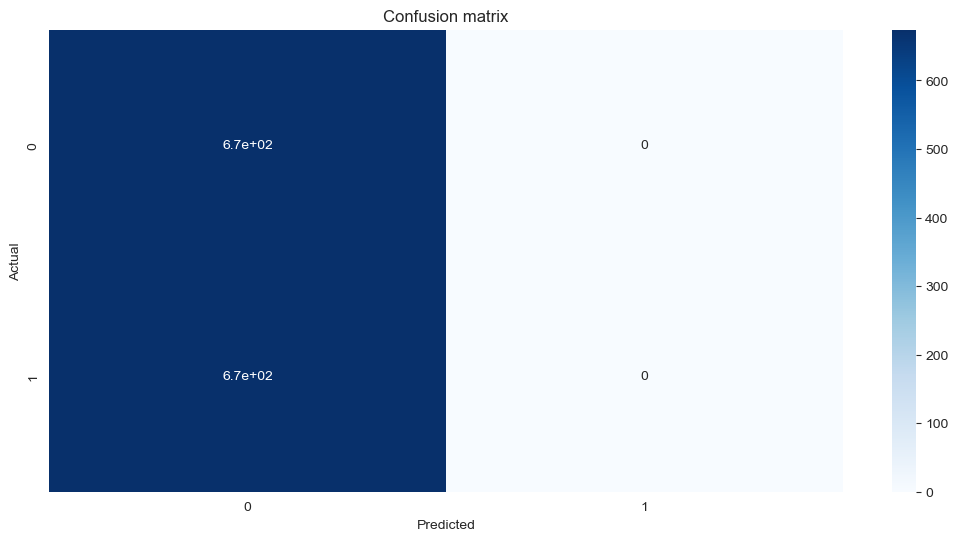

parzen_window_mnbc_pca12_channel_csp15


d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: overflow encountered in long_scalars
  return summation / (N * (h ** dim))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and 

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       674
           1     0.4996    1.0000    0.6663       673

    accuracy                         0.4996      1347
   macro avg     0.2498    0.5000    0.3332      1347
weighted avg     0.2496    0.4996    0.3329      1347



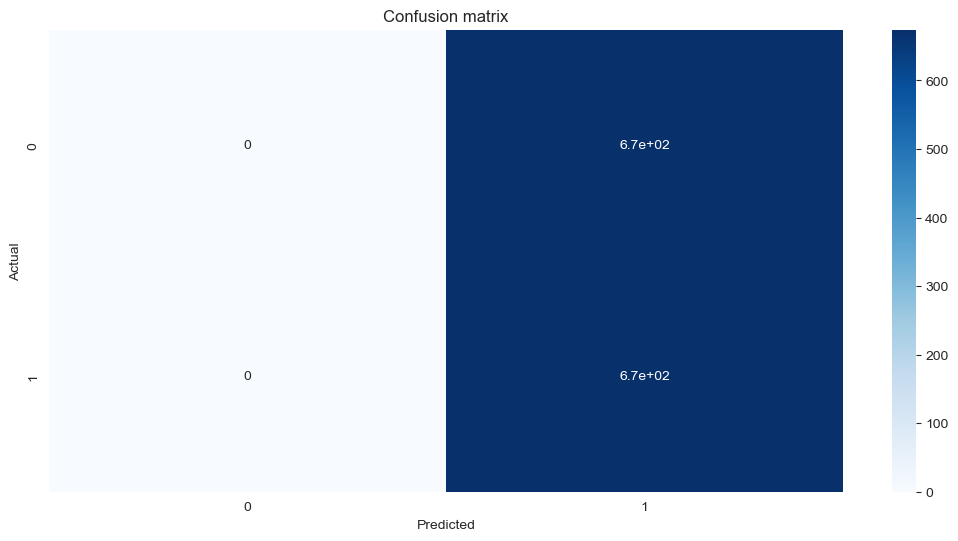

parzen_window_mnbc_fbcsp


d:\Users\User\Documents\TCC Pós Graduação\src\code\novos modelos e tratamentos de dados\lib\NaiveBayesClassifier.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  return summation / (N * (h ** dim))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defi

              precision    recall  f1-score   support

           0     0.5004    1.0000    0.6670       674
           1     0.0000    0.0000    0.0000       673

    accuracy                         0.5004      1347
   macro avg     0.2502    0.5000    0.3335      1347
weighted avg     0.2504    0.5004    0.3337      1347



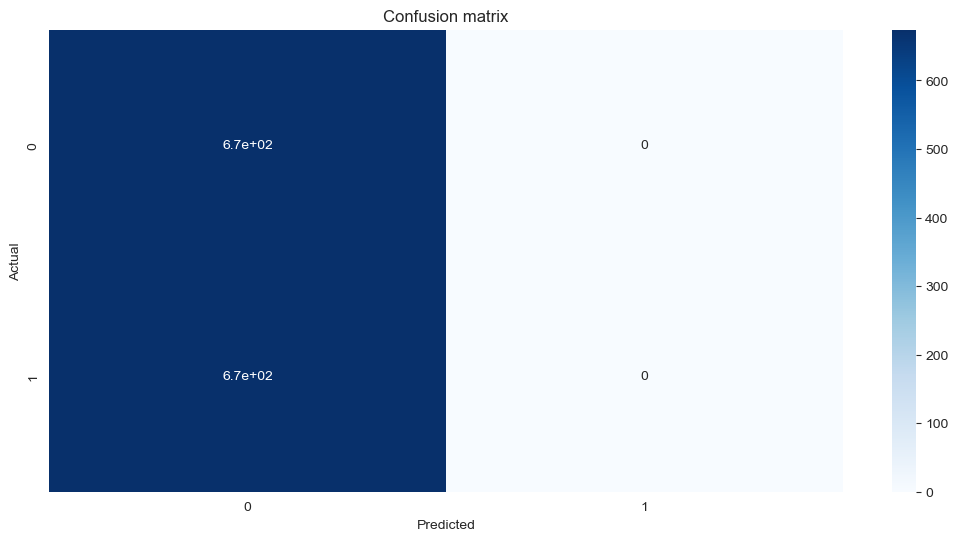

parzen_window_mnbc_fbcsp_with_MIBIF
              precision    recall  f1-score   support

           0     0.5514    0.6929    0.6141       674
           1     0.5860    0.4354    0.4996       673

    accuracy                         0.5642      1347
   macro avg     0.5687    0.5641    0.5568      1347
weighted avg     0.5687    0.5642    0.5569      1347



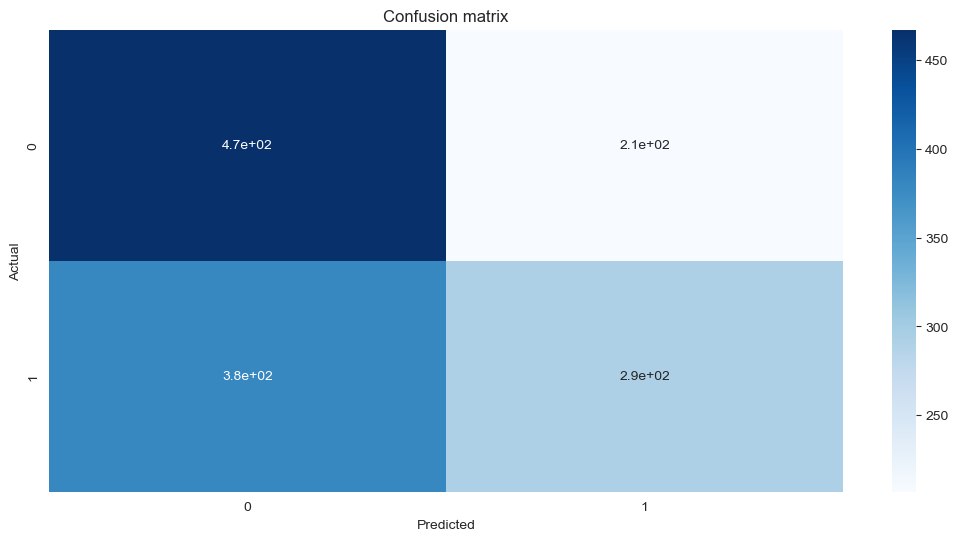

parzen_window_mnbc_fbcsp_pca12_channel_with_MIBIF
              precision    recall  f1-score   support

           0     0.5526    0.6083    0.5791       674
           1     0.5636    0.5067    0.5336       673

    accuracy                         0.5575      1347
   macro avg     0.5581    0.5575    0.5564      1347
weighted avg     0.5581    0.5575    0.5564      1347



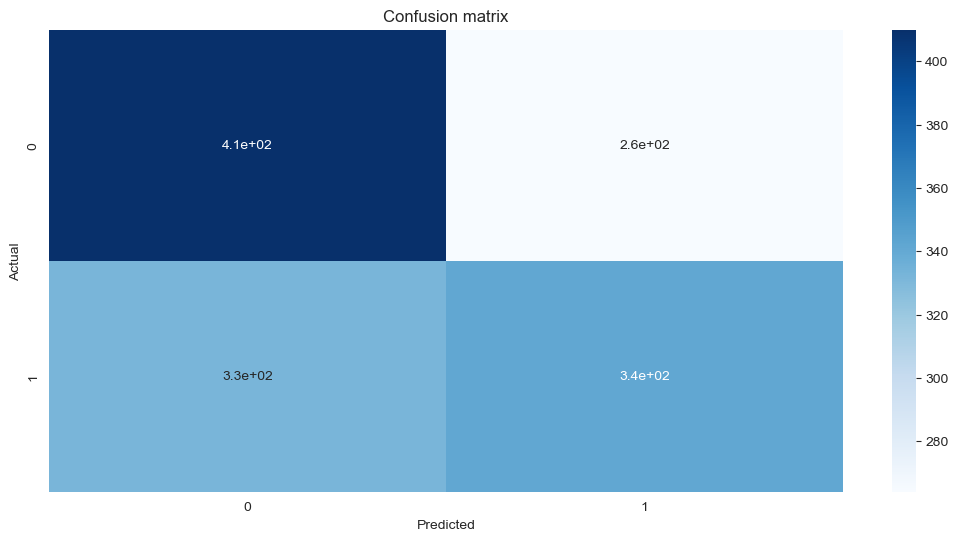

svm_pca12_channel
              precision    recall  f1-score   support

           0     0.4954    0.4822    0.4887       674
           1     0.4949    0.5082    0.5015       673

    accuracy                         0.4952      1347
   macro avg     0.4952    0.4952    0.4951      1347
weighted avg     0.4952    0.4952    0.4951      1347



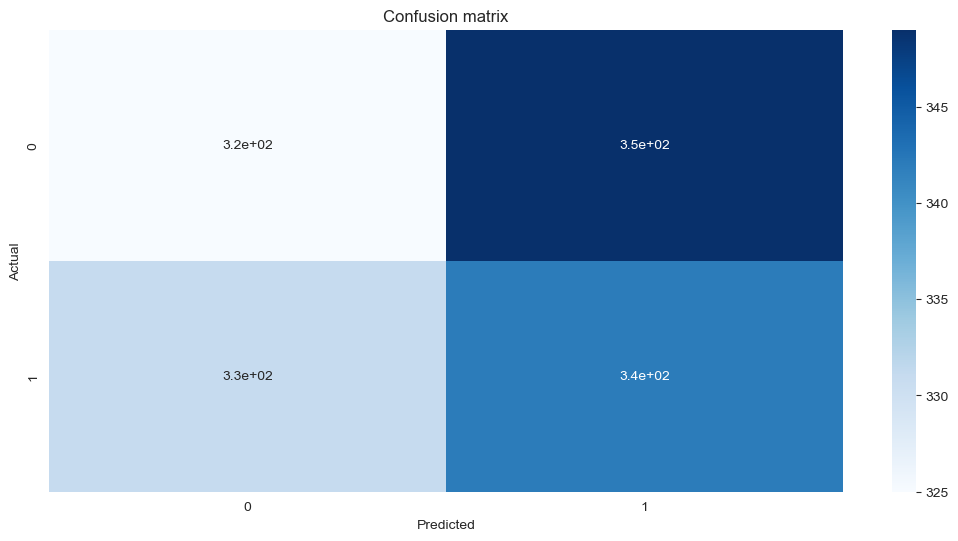

svm_csp4
              precision    recall  f1-score   support

           0     0.5207    0.8027    0.6316       674
           1     0.5682    0.2600    0.3568       673

    accuracy                         0.5316      1347
   macro avg     0.5444    0.5314    0.4942      1347
weighted avg     0.5444    0.5316    0.4943      1347



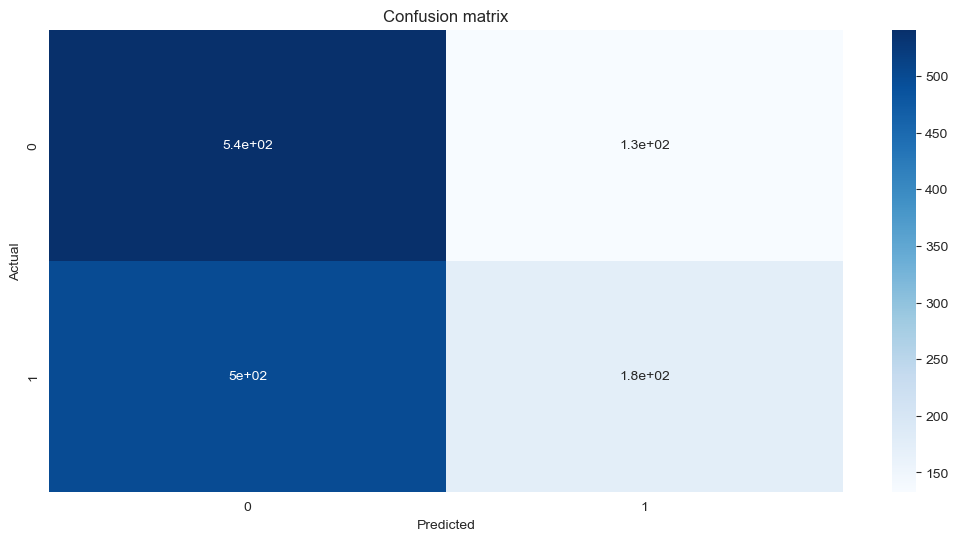

svm_pca12_channel_csp4
              precision    recall  f1-score   support

           0     0.5584    0.6172    0.5863       674
           1     0.5714    0.5111    0.5396       673

    accuracy                         0.5642      1347
   macro avg     0.5649    0.5642    0.5630      1347
weighted avg     0.5649    0.5642    0.5630      1347



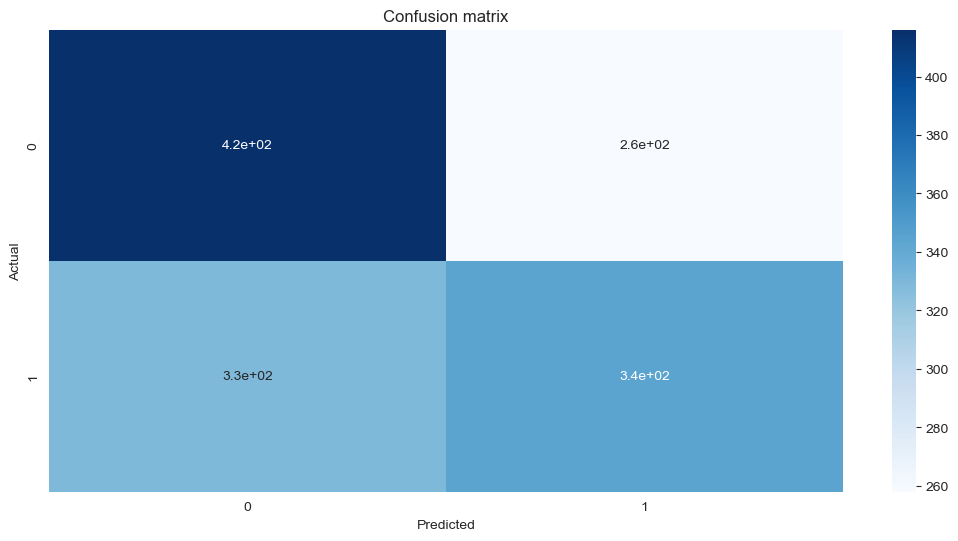

svm_csp15
              precision    recall  f1-score   support

           0     0.5377    0.5401    0.5389       674
           1     0.5373    0.5349    0.5361       673

    accuracy                         0.5375      1347
   macro avg     0.5375    0.5375    0.5375      1347
weighted avg     0.5375    0.5375    0.5375      1347



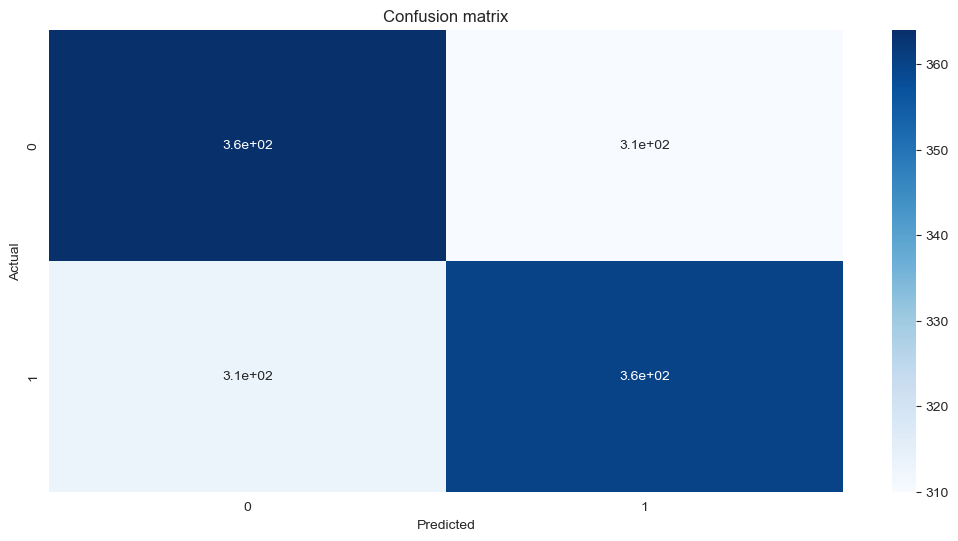

svm_pca12_channel_csp15
              precision    recall  f1-score   support

           0     0.5621    0.5638    0.5630       674
           1     0.5618    0.5602    0.5610       673

    accuracy                         0.5620      1347
   macro avg     0.5620    0.5620    0.5620      1347
weighted avg     0.5620    0.5620    0.5620      1347



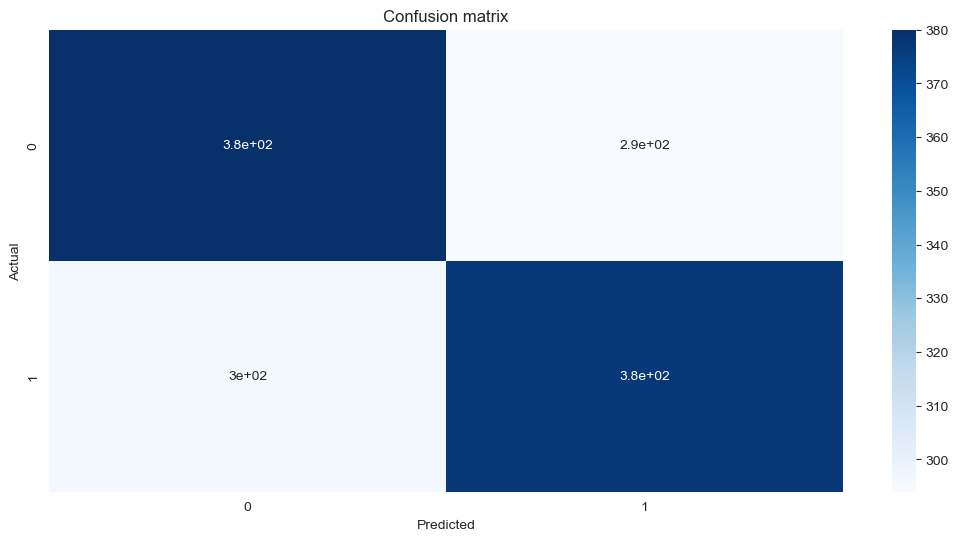

svm_fbcsp
              precision    recall  f1-score   support

           0     0.5578    0.5297    0.5434       674
           1     0.5516    0.5795    0.5652       673

    accuracy                         0.5546      1347
   macro avg     0.5547    0.5546    0.5543      1347
weighted avg     0.5547    0.5546    0.5543      1347



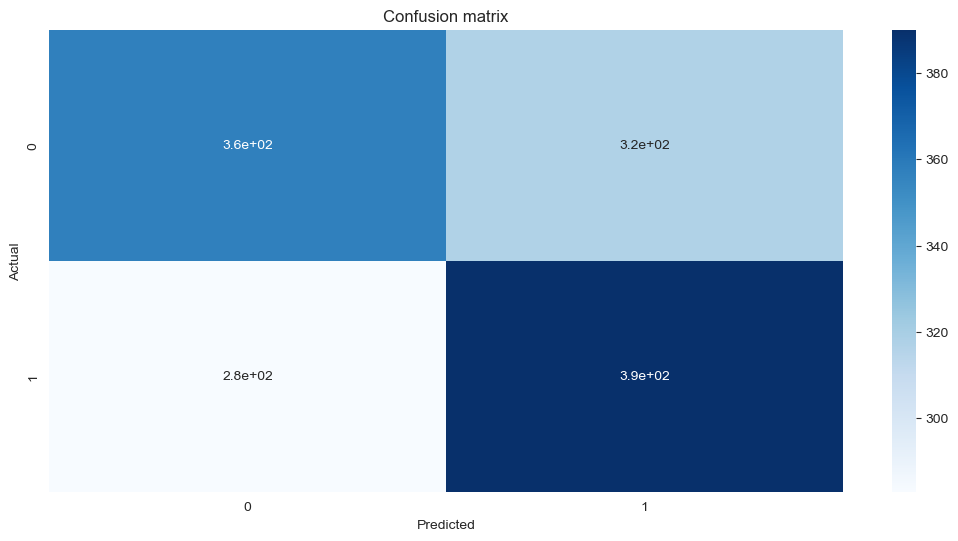

svm_fbcsp_pca12_channel
              precision    recall  f1-score   support

           0     0.5498    0.5326    0.5411       674
           1     0.5461    0.5632    0.5545       673

    accuracy                         0.5479      1347
   macro avg     0.5479    0.5479    0.5478      1347
weighted avg     0.5479    0.5479    0.5478      1347



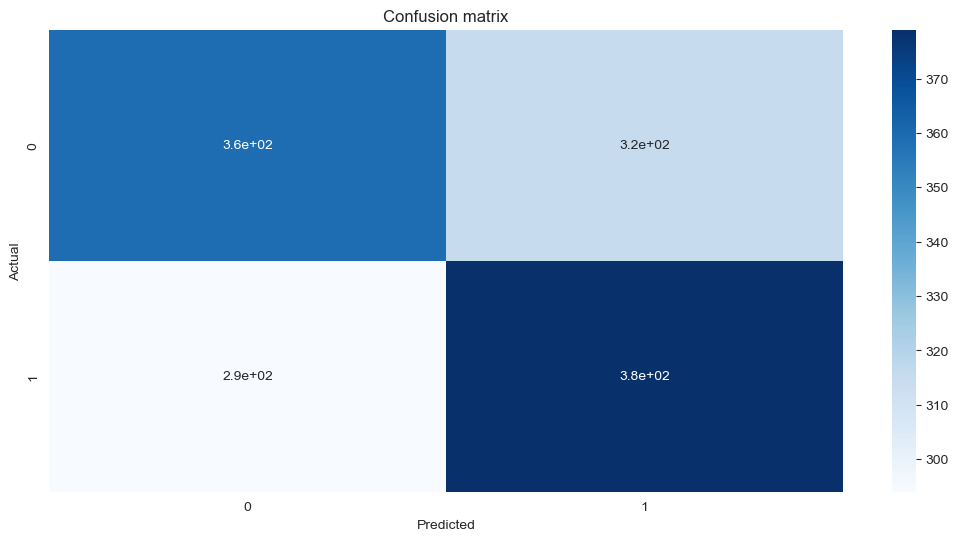

svm_fbcsp_with_MIBIF
              precision    recall  f1-score   support

           0     0.5767    0.5579    0.5671       674
           1     0.5712    0.5899    0.5804       673

    accuracy                         0.5739      1347
   macro avg     0.5740    0.5739    0.5738      1347
weighted avg     0.5740    0.5739    0.5738      1347



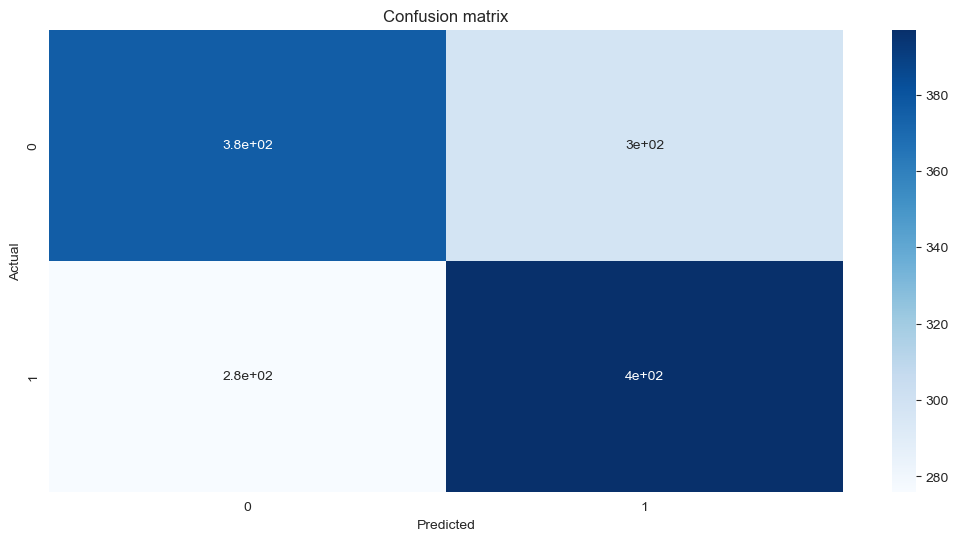

svm_fbcsp_pca12_channel_with_MIBIF
              precision    recall  f1-score   support

           0     0.5591    0.5267    0.5424       674
           1     0.5520    0.5840    0.5675       673

    accuracy                         0.5553      1347
   macro avg     0.5555    0.5553    0.5550      1347
weighted avg     0.5555    0.5553    0.5549      1347



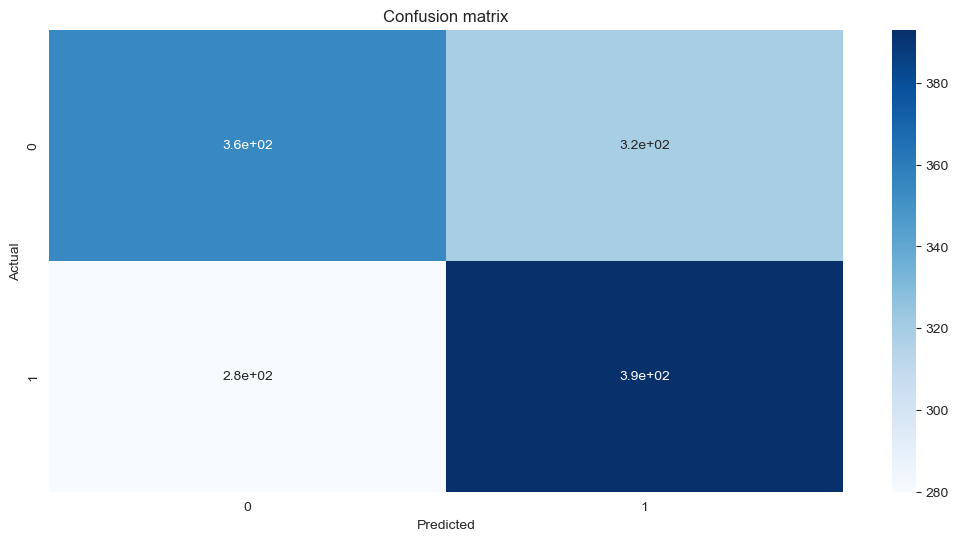

In [36]:
for pipe in Pipes:
    print(pipe.name)
    pipeline = pipe.create_pipeline()
    f1,acc = display_results(pd.DataFrame(y_val)[0],pipeline.predict(pipe.processed_X_val))


In [ ]:
len(y_val)

In [ ]:
np.sum(y_val)

In [ ]:
1347-673

In [ ]:
674/1347


In [ ]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

In [ ]:
pipe.processed_X_val[:, n : (n + w_length)]

In [ ]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data_train.shape[2] - w_length, w_step)

scores_windows = []


# running classifier: test classifier on sliding window
score_this_window = []
for n in w_start:
    transform_list = []
    for event in X_val[:, :, n : (n + w_length)]:
        transform_list.append(pca12_channel.transform(event.T))
    transform_list = np.stack(transform_list, axis=2) 
    X_val_windoed_csp15 = pca12_channel_csp15.transform(transform_list.T)
    score_this_window.append(results_val["lda_pca12_channel_csp15"].score(X_val_windoed_csp15, y_val))
scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs_train.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# #Get Indices (it's the same for all, as suffle is False by default)
# pipe = Pipe("lda_csp4",LinearDiscriminantAnalysis(),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
# pipeline = pipe.create_pipeline()
# cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True,return_indices=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

# print(f"Results for pipeline with {pipe.name}:")
# print("----------------")
# print("Test accuracy scores:", cv_results['test_Accuracy'])
# print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
# print("-----")
# print("Test F1 scores:", cv_results['test_F1'])
# print("Mean test F1:", cv_results['test_F1'].mean())
# print("----------------")
# print("train accuracy scores:", cv_results['train_Accuracy'])
# print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
# print("-----")
# print("train F1 scores:", cv_results['train_F1'])
# print("Mean train F1:", cv_results['train_F1'].mean())
# print("----------------")
# print("Fit time:", cv_results['fit_time'])
# print("Score time:", cv_results['score_time'])
# print()
# print("--------------------------------------------------------------------------------------------")

# indices = cv_results["indices"]["test"]

In [ ]:
# results = {}
# for pipe in Pipes:
#     print(pipe.name)
#     # Create pipeline with the given pipe
#     pipeline = pipe.create_pipeline()
    
#     # Perform cross-validation
#     cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

#     print(f"Results for pipeline with {pipe.name}:")
#     print("----------------")
#     print("Test accuracy scores:", cv_results['test_Accuracy'])
#     print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
#     print("-----")
#     print("Test F1 scores:", cv_results['test_F1'])
#     print("Mean test F1:", cv_results['test_F1'].mean())
#     print("----------------")
#     print("train accuracy scores:", cv_results['train_Accuracy'])
#     print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
#     print("-----")
#     print("train F1 scores:", cv_results['train_F1'])
#     print("Mean train F1:", cv_results['train_F1'].mean())
#     print("----------------")
#     print("Fit time:", cv_results['fit_time'])
#     print("Score time:", cv_results['score_time'])
#     print()
#     print("--------------------------------------------------------------------------------------------")

#     results[pipe.name] = (cv_results)

In [ ]:
# for key, value in results.items(): 
#     print(value['test_Accuracy'])
#     print(",")
# for key, value in results.items(): 
#     print(np.mean(value['test_Accuracy']))
#     print(",")
# for key, value in results.items(): 
#     print(np.max(value['test_Accuracy']))
#     print(",")
# for key, value in results.items(): 
#     print(value['test_F1'])
#     print(",")
# for key, value in results.items(): 
#     print(value['train_Accuracy'])
#     print(",")
# for key, value in results.items(): 
#     print(np.mean(value['train_Accuracy']))
#     print(",")
# for key, value in results.items(): 
#     print(np.max(value['train_Accuracy']))
#     print(",")
# for key, value in results.items(): 
#     print(value['train_F1'])
#     print(",")
# for key, value in results.items(): 
#     print(value['fit_time'])
#     print(",")
# for key, value in results.items(): 
#     print(value['score_time'])
#     print(",")
# - Todos os modelos que receberam apenas PCA não foram capaz de apresentar uma acurária significativamente maior que chance level.
# - O melhor modelo em todas as configurações foi a junção do PCA_data com CSP15
# - Em todos os modelos, a segunda maior média pertence ao modelo CSP15 ou PCA_data com CSP4
# - O melhor modelo foi o LDA, seguido pelo Keras
# f = []
# for key, value in results.items(): 
#     f.append(value['train_Accuracy'])

# np.mean(np.array(f), axis=0)
# f = []
# for key, value in results.items(): 
#     f.append(value['test_Accuracy'])

# np.mean(np.array(f), axis=0)
# Podemos notar que a última separação de treino e teste teve um resultado notavelmente maior que os demais, enquanto as separações 2,3,7,8 foram as piores.
# X_train[indices[9]].shape
# np.floor(np.sqrt(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15).shape[1]+3))

In [ ]:
def aff(array):
    X_std = (array - np.min(array)) / (np.max(array) - np.min(array))
    X_scaled = X_std * (1-0)+0
    return X_scaled

In [ ]:
# # lda_plain = Pipe("lda_csp4",LinearDiscriminantAnalysis(),concat_channels("X_train") ) - Takes too long
# lda_csp4 = Pipe("lda_csp4",LinearDiscriminantAnalysis(),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
# lda_csp15 = Pipe("lda_csp15",LinearDiscriminantAnalysis(),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
# lda_pca12_channel_csp4 = Pipe("lda_pca12_channel_csp4",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
# lda_pca16_data_csp4 = Pipe("lda_pca16_data_csp4",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# # lda_pca900_all = Pipe("lda_pca900_all",LinearDiscriminantAnalysis(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
# lda_pca12_channel = Pipe("lda_pca12_channel",LinearDiscriminantAnalysis(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
# lda_pca16_data = Pipe("lda_pca16_data",LinearDiscriminantAnalysis(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# lda_pca12_channel_csp15 = Pipe("lda_pca12_channel_csp15",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
# lda_pca16_data_csp15 = Pipe("lda_pca16_data_csp15",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# # mnbc_plain = Pipe("mnbc_plain",MultinomialNB(),concat_channels("X_train"),aff)
# mnbc_csp4 = Pipe("mnbc_csp4",MultinomialNB(),transform_csp("X_train",csp4),transform_csp("X_val",csp4),aff)
# mnbc_csp15 = Pipe("mnbc_csp15",MultinomialNB(),transform_csp("X_train",csp15),transform_csp("X_val",csp15),aff)
# mnbc_pca12_channel = Pipe("mnbc_pca12_channel",MultinomialNB(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel),aff)
# mnbc_pca16_data = Pipe("mnbc_pca16_data",MultinomialNB(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data),aff)
# # # # # # # mnbc_pca900_all = Pipe("mnbc_pca900_all",MultinomialNB(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all),aff)
# mnbc_pca12_channel_csp4 = Pipe("mnbc_pca12_channel_csp4",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4),aff)
# mnbc_pca16_data_csp4 = Pipe("mnbc_pca16_data_csp4",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4),aff)
# mnbc_pca12_channel_csp15 = Pipe("mnbc_pca12_channel_csp15",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15),aff)
# mnbc_pca16_data_csp15 = Pipe("mnbc_pca16_data_csp15",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15),aff)
# # MLP_plain = Pipe("MLP_plain",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),concat_channels("X_train")) - Takes too long
# MLP_csp4 = Pipe("MLP_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
# MLP_csp15 = Pipe("MLP_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
# MLP_pca12_channel = Pipe("MLP_pca12_channel",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
# MLP_pca16_data = Pipe("MLP_pca16_data",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# # # # # # # MLP_pca900_all = Pipe("MLP_pca900_all",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
# MLP_pca12_channel_csp4 = Pipe("MLP_pca12_channel_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
# MLP_pca16_data_csp4 = Pipe("MLP_pca16_data_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# MLP_pca12_channel_csp15 = Pipe("MLP_pca12_channel_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
# MLP_pca16_data_csp15 = Pipe("MLP_pca16_data_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# Keras_MLP_csp4 = Pipe("Keras_MLP_csp4",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp4).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
# Keras_MLP_csp15 = Pipe("Keras_MLP_csp15",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp15).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp15),transform_csp("X_val",csp15))

# Keras_MLP_pca12_channel = Pipe("Keras_MLP_pca12_channel",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_concat("X_train",pca12_channel).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
# Keras_MLP_pca16_data = Pipe("Keras_MLP_pca16_data",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_concat("X_train",pca16_data).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
# # # # Keras_MLP_pca900_all = Pipe("Keras_MLP_pca900_all",KerasClassifier(model=create_model, my_params={
# #         "layers":[
# #             # # tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_all_concat("X_train",pca900_all).shape[1],)),
# #             tf.keras.layers.Dense(20, activation='sigmoid'),
# #             tf.keras.layers.Dropout(0.5,seed= 42),
# #             tf.keras.layers.Dense(20, activation='sigmoid'),
# #             tf.keras.layers.Dropout(0.5,seed= 42),
# #             tf.keras.layers.Dense(10, activation='sigmoid'),
# #             tf.keras.layers.Dense(5, activation='sigmoid'),
# #             tf.keras.layers.Dense(3, activation='softmax')
# #         ],
# #         "optimizer":'adam',
# #         "loss": 'sparse_categorical_crossentropy',
# #         "metrics": ['accuracy']
# #     # # # # }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))



# Keras_MLP_pca16_data_csp4 = Pipe("Keras_MLP_pca16_data_csp4",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
# Keras_MLP_pca12_channel_csp4 = Pipe("Keras_MLP_pca12_channel_csp4",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
# Keras_MLP_pca16_data_csp15 = Pipe("Keras_MLP_pca16_data_csp15",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# Keras_MLP_pca12_channel_csp15 = Pipe("Keras_MLP_pca12_channel_csp15",KerasClassifier(model=create_model, my_params={
#         "layers":[
#             tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15).shape[1],)),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(20, activation='sigmoid'),
#             tf.keras.layers.Dropout(0.5,seed= 42),
#             tf.keras.layers.Dense(10, activation='sigmoid'),
#             tf.keras.layers.Dense(5, activation='sigmoid'),
#             tf.keras.layers.Dense(3, activation='softmax')
#         ],
#         "optimizer":'adam',
#         "loss": 'sparse_categorical_crossentropy',
#         "metrics": ['accuracy']
#     }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))




# Pipes = [
#     lda_csp4,
#     lda_csp15,
#     lda_pca12_channel_csp4,
#     lda_pca12_channel_csp15,
#     lda_pca16_data_csp4,
#     lda_pca16_data_csp15,
#     # mnbc_plain,
#     mnbc_csp4,
#     mnbc_csp15,
#     mnbc_pca12_channel_csp4,
#     mnbc_pca12_channel_csp15,
#     mnbc_pca16_data_csp4,
#     mnbc_pca16_data_csp15,
#     # MLP_plain,
#     MLP_csp4,
#     MLP_csp15,
#     MLP_pca12_channel_csp4,
#     MLP_pca12_channel_csp15,
#     MLP_pca16_data_csp4,
#     MLP_pca16_data_csp15,
#     Keras_MLP_csp4,
#     Keras_MLP_csp15,
#     Keras_MLP_pca12_channel_csp4,
#     Keras_MLP_pca12_channel_csp15,
#     Keras_MLP_pca16_data_csp4,
#     Keras_MLP_pca16_data_csp15,
    
    
#     lda_pca12_channel,
#     lda_pca16_data,
#     # lda_pca900_all,
    
#     mnbc_pca12_channel,
#     mnbc_pca16_data,
#     # mnbc_pca900_all,
#     MLP_pca12_channel,
#     MLP_pca16_data,
#     # MLP_pca900_all,
#     Keras_MLP_pca12_channel,
#     Keras_MLP_pca16_data,
#     # Keras_MLP_pca900_all,
# ]


In [ ]:
# results_val = {}
# for pipe in Pipes:
#     print(pipe.name)
#     # Create pipeline with the given pipe
#     pipeline = pipe.create_pipeline()
    
#     # Perform cross-validation
#     pipeline.fit( pipe.processed_X_train, y_train)
#     train_score = pipeline.score(pipe.processed_X_train,y_train)
#     val_score = pipeline.score(pipe.processed_X_val,y_val)


#     print(f"Results for pipeline with {pipe.name}:")
#     print("----------------")
#     print("Test accuracy scores:", val_score)
#     print("----------------")
#     print("train accuracy scores:", train_score)
#     print()
#     print("--------------------------------------------------------------------------------------------")

#     results_val[pipe.name] = (pipeline)
    


In [ ]:
# for pipe in Pipes:
#     f1,acc = display_results(pd.DataFrame(y_val)[0],pipe.model.predict(pipe.processed_X_val))

In [ ]:
# sfreq = raw.info["sfreq"]
# w_length = int(sfreq * 0.5)  # running classifier: window length
# w_step = int(sfreq * 0.1)  # running classifier: window step size
# w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

In [ ]:
# pipe.processed_X_val[:, n : (n + w_length)]

In [ ]:
# results_val["lda_pca12_channel_csp4"]

In [ ]:
# sfreq = raw.info["sfreq"]
# w_length = int(sfreq * 0.5)  # running classifier: window length
# w_step = int(sfreq * 0.1)  # running classifier: window step size
# w_start = np.arange(0, epochs_data_train.shape[2] - w_length, w_step)

# scores_windows = []


# # running classifier: test classifier on sliding window
# score_this_window = []
# for n in w_start:
#     transform_list = []
#     for event in X_val[:, :, n : (n + w_length)]:
#         transform_list.append(pca12_channel.transform(event.T))
#     transform_list = np.stack(transform_list, axis=2) 
#     X_val_windoed_csp15 = pca12_channel_csp15.transform(transform_list.T)
#     score_this_window.append(results_val["lda_pca12_channel_csp15"].score(X_val_windoed_csp15, y_val))
# scores_windows.append(score_this_window)

# # Plot scores over time
# w_times = (w_start + w_length / 2.0) / sfreq + epochs_train.tmin

# plt.figure()
# plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
# plt.axvline(0, linestyle="--", color="k", label="Onset")
# plt.axhline(0.5, linestyle="-", color="k", label="Chance")
# plt.xlabel("time (s)")
# plt.ylabel("classification accuracy")
# plt.title("Classification score over time")
# plt.legend(loc="lower right")
# plt.show()